# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [17]:
import pyarrow
import logging
import sys
from matplotlib_venn import venn3
from pandas.tseries.offsets import MonthEnd
from pandas import DataFrame
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import scipy
from surprise import Dataset, Reader, SVD, accuracy, NormalPredictor
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
from contextlib import asynccontextmanager
from fastapi import FastAPI
from contextlib import asynccontextmanager
import requests

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [ ]:
tracks = pd.read_parquet("./data/tracks.parquet")
catalog_names = pd.read_parquet("./data/catalog_names.parquet")
interactions = pd.read_parquet("./data/interactions.parquet")

In [20]:
print("Данные загружены")
print("tracks:", tracks.shape, "catalog_names:", catalog_names.shape, "interactions:", interactions.shape)

Данные загружены
tracks: (1000000, 4) catalog_names: (1812471, 3) interactions: (222629898, 4)


In [21]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [22]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [23]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [24]:
catalog_names["type"].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [25]:
catalog_names.query("type == 'genre'")

,id,type,name
812305,0,genre,all
812306,1,genre,eastern
812307,2,genre,rusrock
812308,3,genre,rusrap
812309,4,genre,postrock
...,...,...,...
812466,1182,genre,balkan
812467,1197,genre,experimental
812468,1370,genre,europop
812469,1484,genre,meditation


In [28]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [ ]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

#### 1. Проверка общей целостности данных
- Количество строк и дубликаты:

In [ ]:
print("Уникальных track_id:", tracks['track_id'].nunique(), "из", len(tracks))
print("Уникальных catalog_ids:", catalog_names['id'].nunique(), "из", len(catalog_names))
print("Уникальных interactions:", interactions.drop_duplicates().shape[0], "из", len(interactions))

Уникальных track_id: 1000000 из 1000000
Уникальных catalog_ids: 1776697 из 1812471


In [ ]:
# проверим catalog_ids на дубликаты
print("Уникальных catalog_ids:", catalog_names.drop_duplicates(['type', 'name'], keep='first').shape[0], "из", len(catalog_names))

Уникальных catalog_ids: 1122702 из 1812471


- проверка пропусков

In [ ]:
print("\n🔎 Проверка пропусков")
print(tracks.isna().sum())
print(catalog_names.isna().sum())
print(interactions.isna().sum())


🔎 Проверка пропусков
track_id    0
albums      0
artists     0
genres      0
dtype: int64
id      0
type    0
name    0
dtype: int64
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64


#### 2. Проверка связей между таблицами

In [ ]:
missing_tracks = set(interactions['track_id']) - set(tracks['track_id'])
print("Нет в tracks:", len(missing_tracks), "track_id")

Нет в tracks: 0 track_id


если > 0, значит есть "прослушивания" треков, которых нет в каталоге

если < 0, значит есть треки, которые вообще не слушали

In [ ]:
flat_albums = set(a for lst in tracks['albums'] for a in lst)
flat_artists = set(a for lst in tracks['artists'] for a in lst)
flat_genres = set(g for lst in tracks['genres'] for g in lst)

missing_albums = flat_albums - set(catalog_names.loc[catalog_names['type']=="album", "id"])
missing_artists = flat_artists - set(catalog_names.loc[catalog_names['type']=="artist", "id"])
missing_genres = flat_genres - set(catalog_names.loc[catalog_names['type']=="genre", "id"])

print("Нет в catalog_names (альбомы):", len(missing_albums))
print("Нет в catalog_names (артисты):", len(missing_artists))
print("Нет в catalog_names (жанры):", len(missing_genres))

Нет в catalog_names (альбомы): 0
Нет в catalog_names (артисты): 0
Нет в catalog_names (жанры): 30


#### 3. Проверка временной логики

In [ ]:
interactions["started_at"] = pd.to_datetime(interactions["started_at"])

# Проверка последовательности track_seq
seq_check = interactions.groupby("user_id")["track_seq"].apply(
    lambda x: (x != range(1, len(x)+1)).sum()
)
print("Нарушений track_seq:", seq_check.sum())

Нарушений track_seq: 0


In [ ]:
interactions.query()

In [ ]:
# Проверка сортировки по датам
bad_time = (
    interactions
    .sort_values(["user_id", "started_at"])
    .groupby("user_id")["started_at"]
    .diff().dt.days < 0
).sum()
print("Нарушений хронологии дат:", bad_time)

Нарушений хронологии дат: 0


отрицательная разница означала бы, что порядок дат нарушен.

#### 4. Логические проверки

In [ ]:
no_genre = (tracks["genres"].apply(len) == 0).sum()
no_artist = (tracks["artists"].apply(len) == 0).sum()
no_album = (tracks["albums"].apply(len) == 0).sum()

print("Треки без жанров:", no_genre)
print("Треки без артистов:", no_artist)
print("Треки без альбомов:", no_album)

Треки без жанров: 3687
Треки без артистов: 15369
Треки без альбомов: 18


#### 5. Статистики

In [ ]:
print("Прослушиваний на пользователя:")
print(interactions.groupby("user_id")["track_id"].count().describe())

tracks_not_played = set(tracks['track_id']) - set(interactions['track_id'])
print("Треков без прослушиваний:", len(tracks_not_played))

Прослушиваний на пользователя:
count    1.373221e+06
mean     1.621224e+02
std      3.512846e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.540000e+02
max      1.663700e+04
Name: track_id, dtype: float64
Треков без прослушиваний: 0


#### Сформируем Wide-таблицу

In [ ]:
albums_dict = catalog_names.query("type == 'album'").set_index("id")["name"].to_dict()
artists_dict = catalog_names.query("type == 'artist'").set_index("id")["name"].to_dict()
genres_dict = catalog_names.query("type == 'genre'").set_index("id")["name"].to_dict()
tracks_dict = catalog_names.query("type == 'track'").set_index("id")["name"].to_dict()

In [ ]:
items_wide = tracks.copy()

items_wide["track_name"] = items_wide["track_id"].map(tracks_dict)
items_wide["album_names"] = items_wide["albums"].apply(lambda x: [albums_dict.get(i, None) for i in x])
items_wide["artist_names"] = items_wide["artists"].apply(lambda x: [artists_dict.get(i, None) for i in x])
items_wide["genre_names"] = items_wide["genres"].apply(lambda x: [genres_dict.get(i, None) for i in x])
items_wide.head(3)

,track_id,albums,artists,genres,track_name,album_names,artist_names,genre_names
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]


In [ ]:
catalog_names[catalog_names["id"].isin([3, 2490753])]

,id,type,name
0,3,album,Taller Children
154612,2490753,album,Taller Children
812308,3,genre,rusrap


In [ ]:
catalog_names[catalog_names["id"].isin([12, 214, 2490809])]

,id,type,name
1,12,album,Wild Young Hearts
102,214,album,Wild Young Hearts
154625,2490809,album,Wild Young Hearts
658728,12,artist,Phil Everly
812317,12,genre,shanson


#### ========= в данных есть проблемы с идентификаторами и типами. ==========

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

1. Повторяющиеся id в разных типах

В catalog_names один и тот же id встречается с разными значениями в колонке type.
Например:

- id = 3  → album = Taller Children
- id = 3  → genre = rusrap


То есть id=3 одновременно и альбом, и жанр — это явная проблема.
По-хорошему id должен быть уникален внутри всей таблицы справочника.

2. Повторные названия с разными id

Один и тот же альбом встречается с разными идентификаторами:

- id = 3, 2490753 → Taller Children
- id = 12, 214, 2490809 → Wild Young Hearts


Это может означать:

- дубль в источниках данных,

- или же разные версии альбома (например, deluxe edition и обычная версия), но у них одинаковое название !!!!!.

Без дополнительной нормализации эти альбомы будут считаться разными.

3. Смешение id между разными сущностями

Пример с id = 12:

- 12 → album Wild Young Hearts
- 12 → artist Phil Everly
- 12 → genre shanson


Здесь один и тот же идентификатор одновременно ссылается на альбом, артиста и жанр!
Это критическая проблема — система рекомендаций будет путать сущности.

#### Вывод:
- Из-за таких пересечений появляются дубли в album_names (один и тот же альбом повторяется несколько раз в списке).

- Также возможно попадание «лишних» жанров или артистов, если id пересекается.

- Если оставить как есть — рекомендации будут «грязные» (треки могут оказаться привязаны к неправильным жанрам или альбомам).

Для нормализации нужно:

    1. Проверить уникальность пары (id, type) → удалить или почистить дубликаты.

    2. При объединении использовать и id, и type, а не только id.

In [ ]:
# Проверим, есть ли у одного id несколько типов
id_type_counts = catalog_names.groupby("id")["type"].nunique()
conflicting_ids = id_type_counts[id_type_counts > 1].index

print(f"Количество id с несколькими типами: {len(conflicting_ids)}")
print("Примеры конфликтов:")
print(catalog_names[catalog_names["id"].isin(conflicting_ids)].head(15))

Количество id с несколькими типами: 34644
Примеры конфликтов:
    id   type                                               name
0    3  album                                    Taller Children
1   12  album                                  Wild Young Hearts
2   13  album                                      Lonesome Crow
3   17  album                                      Graffiti Soul
4   26  album                                     Blues Six Pack
5   27  album  Authorized Bootleg - Live/Tokyo Dome - Tokyo, ...
6   29  album                               Foot Of The Mountain
7   34  album                             Self Taught Learner EP
8   36  album                                     A Secret Place
9   39  album                                         Sunny Days
10  43  album                                     Blues Six Pack
11  45  album                                     Blues Six Pack
12  48  album                 THE E.N.D. (THE ENERGY NEVER DIES)
13  49  album               

In [ ]:
catalog_names[catalog_names["id"].isin([3])]

,id,type,name
0,3,album,Taller Children
812308,3,genre,rusrap


In [ ]:
# Проверим дубли по (id, type, name)
duplicates = catalog_names.duplicated(subset=["id", "type", "name"]).sum()
print(f"Количество полных дублей (id, type, name): {duplicates}")

Количество полных дублей (id, type, name): 0


In [ ]:
# Проверим дубли по (id, type)
duplicates = catalog_names.duplicated(subset=["id", "type"]).sum()
print(f"Количество полных дублей (id, type): {duplicates}")

Количество полных дублей (id, type): 0


In [ ]:
# Проверим случаи, когда одно и то же название встречается с разными id
name_id_counts = catalog_names.groupby("name")["id"].nunique()
duplicate_names = name_id_counts[name_id_counts > 1].index

print(f"Количество названий с разными id: {len(duplicate_names)}")
print("Примеры названий с разными id:")
print(catalog_names[catalog_names["name"].isin(duplicate_names)].sort_values(by="name", ascending=False).head(25))

Количество названий с разными id: 255730
Примеры названий с разными id:
               id   type                            name
573642   14404719  album  🤘🏻 Rock Clásicos 80&90&2000 🤘🏻
593814   15804713  album  🤘🏻 Rock Clásicos 80&90&2000 🤘🏻
1670954  69610973  track                 후폭풍 (Bad Dream)
1670791  69608070  track                 후폭풍 (Bad Dream)
1670394  69605161  track                   피터팬 Peter Pan
1670431  69605383  track                   피터팬 Peter Pan
1670505  69607025  track                  피카부 Peek-A-Boo
1670364  69604890  track                  피카부 Peek-A-Boo
1691374  72293798  track       피아노 Faded In My Last Song
1705070  73947615  track       피아노 Faded In My Last Song
473501   10109065  album       추억으로 나는 간다 As Memories Go
1620153  63502148  track       추억으로 나는 간다 As Memories Go
1670659  69607699  track                지금 우리 (City 127)
1670687  69607796  track                지금 우리 (City 127)
1670253  69604334  track                     중독 Overdose
1670898  6960899

#### План очистки

1. Удалить точные дубликаты (id, type, name).

2. Буду работать с (id, type) как ключом для маппинга, а не только с id, чтобы избежать коллизий, поэтому устранять конфликты, где один id имеет несколько type не буду (как вариант можно было оставить только один вариант (например, приоритет track > artist > album > genre).

Например, 3_album → Taller Children, 3_genre → rusrap.

3. Одинаковые названия с разными id — оставим, но буду помнить, что маппинг надо строить именно по (id, type).

In [8]:
# 1. Убираем точные дубликаты
catalog_clean = catalog_names.drop_duplicates(subset=["id", "type", "name"])

In [9]:
# 1. Убираем точные дубликаты
catalog_clean = catalog_names.drop_duplicates(subset=["id", "type"])

In [ ]:
# 2. Проверяем id с несколькими типами
conflicting_ids = (
    catalog_clean.groupby("id")["type"].nunique()
    .loc[lambda x: x > 1]
    .index
)

print(f"ID с конфликтующими типами: {len(conflicting_ids)}")

ID с конфликтующими типами: 34644


In [7]:
# 3. Добавляем "ключ" вида id_type для уникальности
catalog_clean["id_type"] = catalog_clean["id"].astype(str) + "_" + catalog_clean["type"]

# Теперь у нас нет коллизий
catalog_clean.sort_values(by=["name","type"], ascending=False).head(25)

,id,type,name,id_type
1682578,71229497,track,🧺 Picnics (S04E07) + Transcript,71229497_track
1624044,63880930,track,🧸 Toys (S02E08) + Transcript,63880930_track
1708710,74597869,track,🧭 Traveling (S05E01) + Transcript,74597869_track
1632665,64726613,track,🧬 Science (Season 2 Finale 🏁) + Transcript,64726613_track
1641925,65866709,track,🧘‍♂️ Morning routine (S03E03) + Transcript,65866709_track
1645990,66462914,track,🧔 Lost and Found - Stories with Rory #1 (+ Tra...,66462914_track
1650430,67030575,track,🧔 Helping others - Stories with Rory #2 (+ Tra...,67030575_track
1625400,64000823,track,"🦠 💸 😷 «Хм, кажется, я потерял 50% выручки». Ка...",64000823_track
1654887,67625424,track,🦗 Insects (S03E13) + Transcript,67625424_track
1680632,70963640,track,🥴«Без вины виноватые». Залетаем в четвертый се...,70963640_track


In [ ]:
# выберем треки, у которых название состоит из 1–2 символов
catalog_clean[catalog_clean["name"].str.len() < 2].query("type =='album'").sort_values(by="name")


,id,type,name,id_type
427433,8379800,album,!,8379800_album
135571,2154090,album,!,2154090_album
131744,2081150,album,!,2081150_album
425113,8276982,album,!,8276982_album
425114,8276983,album,!,8276983_album
...,...,...,...,...
419608,8088932,album,∞,8088932_album
453924,9415118,album,Ⰰ,9415118_album
515562,11732026,album,Ⰱ,11732026_album
538609,12662167,album,他,12662167_album


In [ ]:
catalog_clean[catalog_clean["name"].str.len() < 2].query("type =='album'")["name"].value_counts()

name
X    58
7    51
V    45
3    34
I    28
     ..
А     1
Q     1
Ⅴ     1
y     1
o     1
Name: count, Length: 74, dtype: int64

- Wide-таблица

In [19]:
# составляем словари
albums_dict = catalog_clean.query("type == 'album'").set_index("id")["name"].to_dict()
artists_dict = catalog_clean.query("type == 'artist'").set_index("id")["name"].to_dict()
genres_dict = catalog_clean.query("type == 'genre'").set_index("id")["name"].to_dict()
tracks_dict = catalog_clean.query("type == 'track'").set_index("id")["name"].to_dict()

In [9]:
items_wide = tracks.copy()

items_wide["track_name"] = items_wide["track_id"].map(tracks_dict)
items_wide["album_names"] = items_wide["albums"].apply(lambda x: [albums_dict.get(i, None) for i in x])
items_wide["artist_names"] = items_wide["artists"].apply(lambda x: [artists_dict.get(i, None) for i in x])
items_wide["genre_names"] = items_wide["genres"].apply(lambda x: [genres_dict.get(i, None) for i in x])
items_wide.tail(7)

,track_id,albums,artists,genres,track_name,album_names,artist_names,genre_names
999993,101458360,[21394533],"[314001, 40324, 7237963]",[13],KULT,[KULT],"[grandson, Steve Aoki, Jasiah]",[alternative]
999994,101476180,[21399110],[6207325],"[11, 20]",Февраль,[Февраль],[Gafur],"[pop, ruspop]"
999995,101478482,[21399811],[5540395],"[3, 75]",На лицо,[На лицо],[FLESH],"[rusrap, rap]"
999996,101490148,[21403052],[9078726],"[11, 20]",Без капли мысли,[Без капли мысли],[Даня Милохин],"[pop, ruspop]"
999997,101493057,[21403883],[11865715],"[44, 75]",SKITTLES,[SKITTLES],[WhyBaby?],"[foreignrap, rap]"
999998,101495927,[21404975],[4462686],"[3, 75]",Москва,[Москва],[Yanix],"[rusrap, rap]"
999999,101521819,[21414638],[5056591],"[3, 75]",Вокзал,[Вокзал],[Джарахов],"[rusrap, rap]"


In [ ]:
del albums_dict
del artists_dict
del genres_dict
del tracks_dict

# === ЭТАП 2 ===

# EDA

In [ ]:
import seaborn as sns

Распределение количества прослушанных треков.

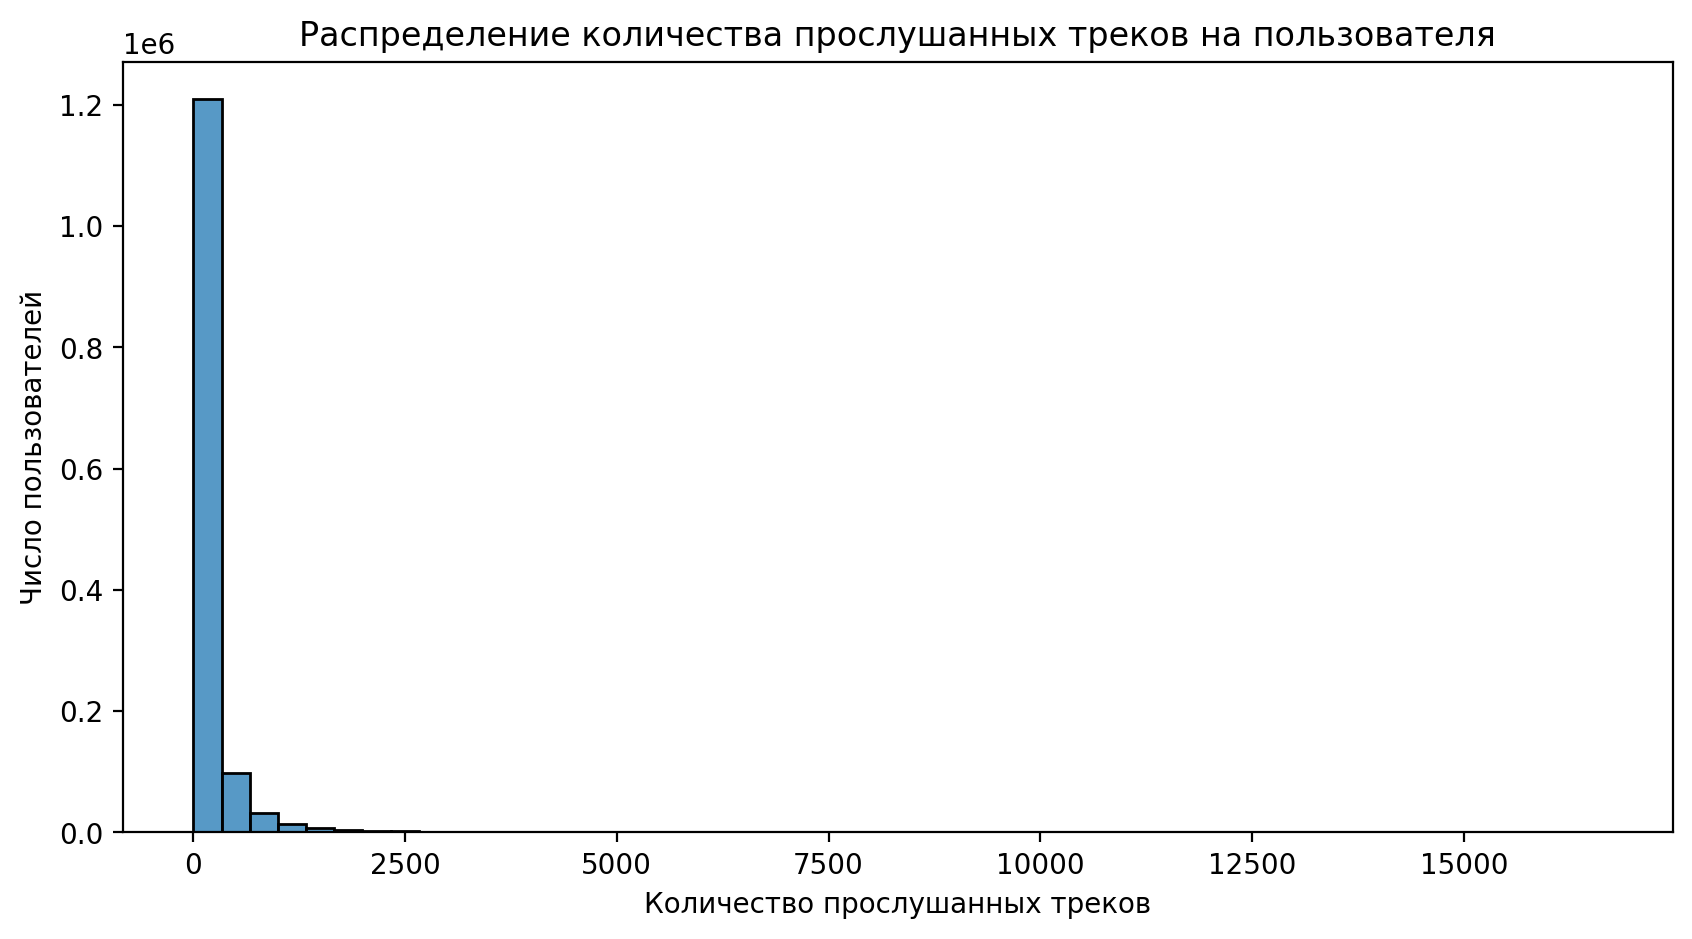

In [ ]:
# количество прослушанных треков на пользователя
user_track_counts = interactions.groupby("user_id")["track_id"].count()

plt.figure(figsize=(10, 5))
sns.histplot(user_track_counts, bins=50, kde=False)
plt.xlabel("Количество прослушанных треков")
plt.ylabel("Число пользователей")
plt.title("Распределение количества прослушанных треков на пользователя")
plt.savefig('./EDA/user_track_counts.png')
plt.show()

Наиболее популярные треки

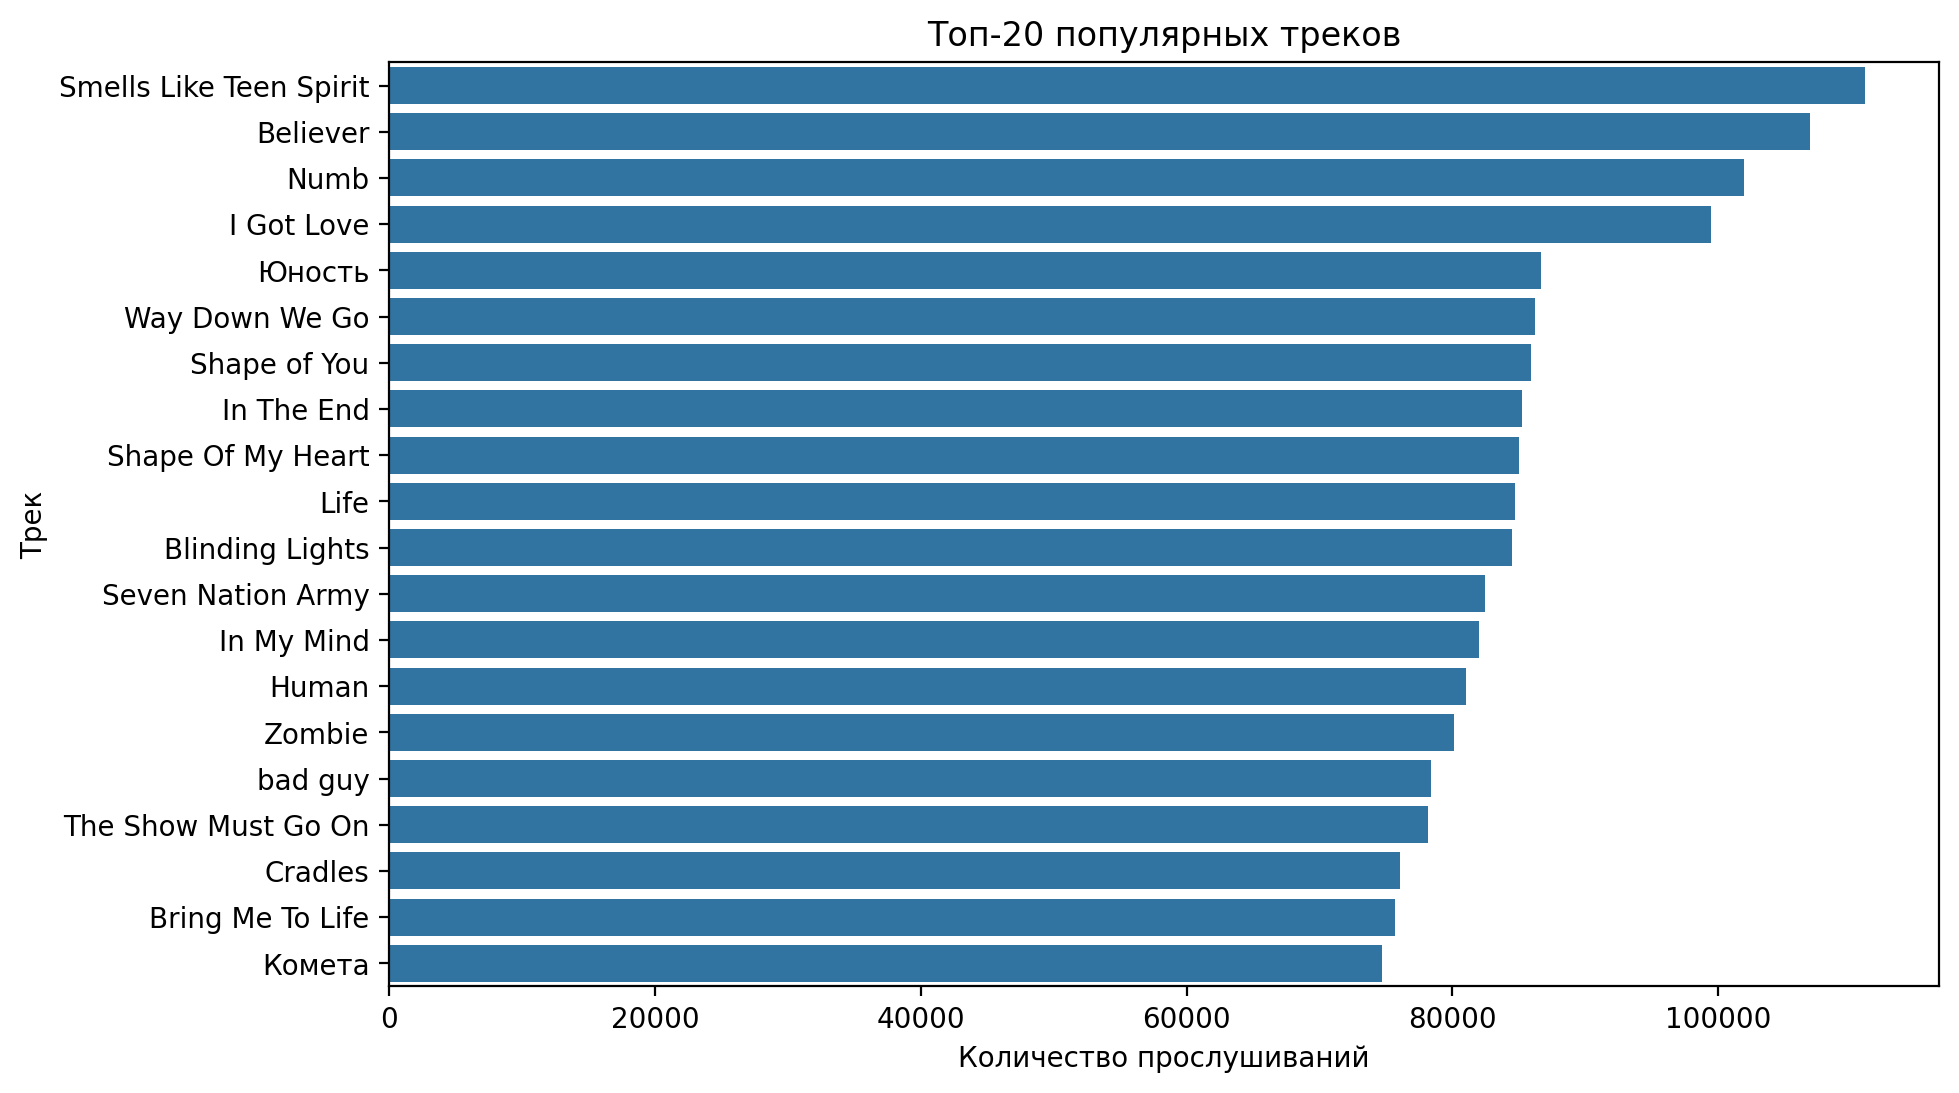

In [ ]:
# топ-20 треков
top_tracks = interactions["track_id"].value_counts().head(20).reset_index()
top_tracks.columns = ["track_id", "count"]

# добавим названия треков
top_tracks = top_tracks.merge(items_wide[["track_id", "track_name"]], on="track_id", how="left")

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tracks, y="track_name", x="count")
plt.xlabel("Количество прослушиваний")
plt.ylabel("Трек")
plt.title("Топ-20 популярных треков")
plt.savefig("./EDA/top_tracks.png")
plt.show()

Наиболее популярные жанры

In [ ]:
interactions = interactions.sort_values(by="started_at", ascending=False).head(25000000)

In [ ]:
# развернём список жанров по трекам
genres_exploded = items_wide[["track_id", "genre_names"]].explode("genre_names")

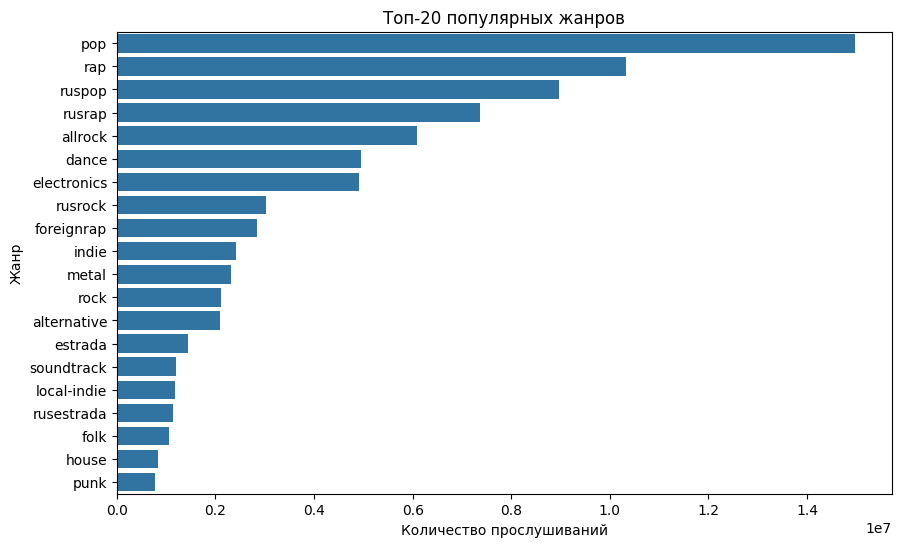

In [ ]:
# посчитаем количество прослушиваний по жанрам
interactions_with_genres = interactions.merge(genres_exploded, on="track_id", how="left")
top_genres = interactions_with_genres["genre_names"].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.xlabel("Количество прослушиваний")
plt.ylabel("Жанр")
plt.title("Топ-20 популярных жанров")
plt.savefig("./EDA/top_genres.png")
plt.show()

Треки, которые никто не прослушал

In [ ]:
# все треки
all_tracks = set(items_wide["track_id"])
# треки, которые слушали
listened_tracks = set(interactions["track_id"])
# невостребованные треки
unlistened_tracks = all_tracks - listened_tracks

print(f"Количество треков, которые никто не слушал: {len(unlistened_tracks)}")

items_wide[items_wide["track_id"].isin(list(unlistened_tracks))].head()

Количество треков, которые никто не слушал: 0


,track_id,albums,artists,genres,track_name,album_names,artist_names,genre_names


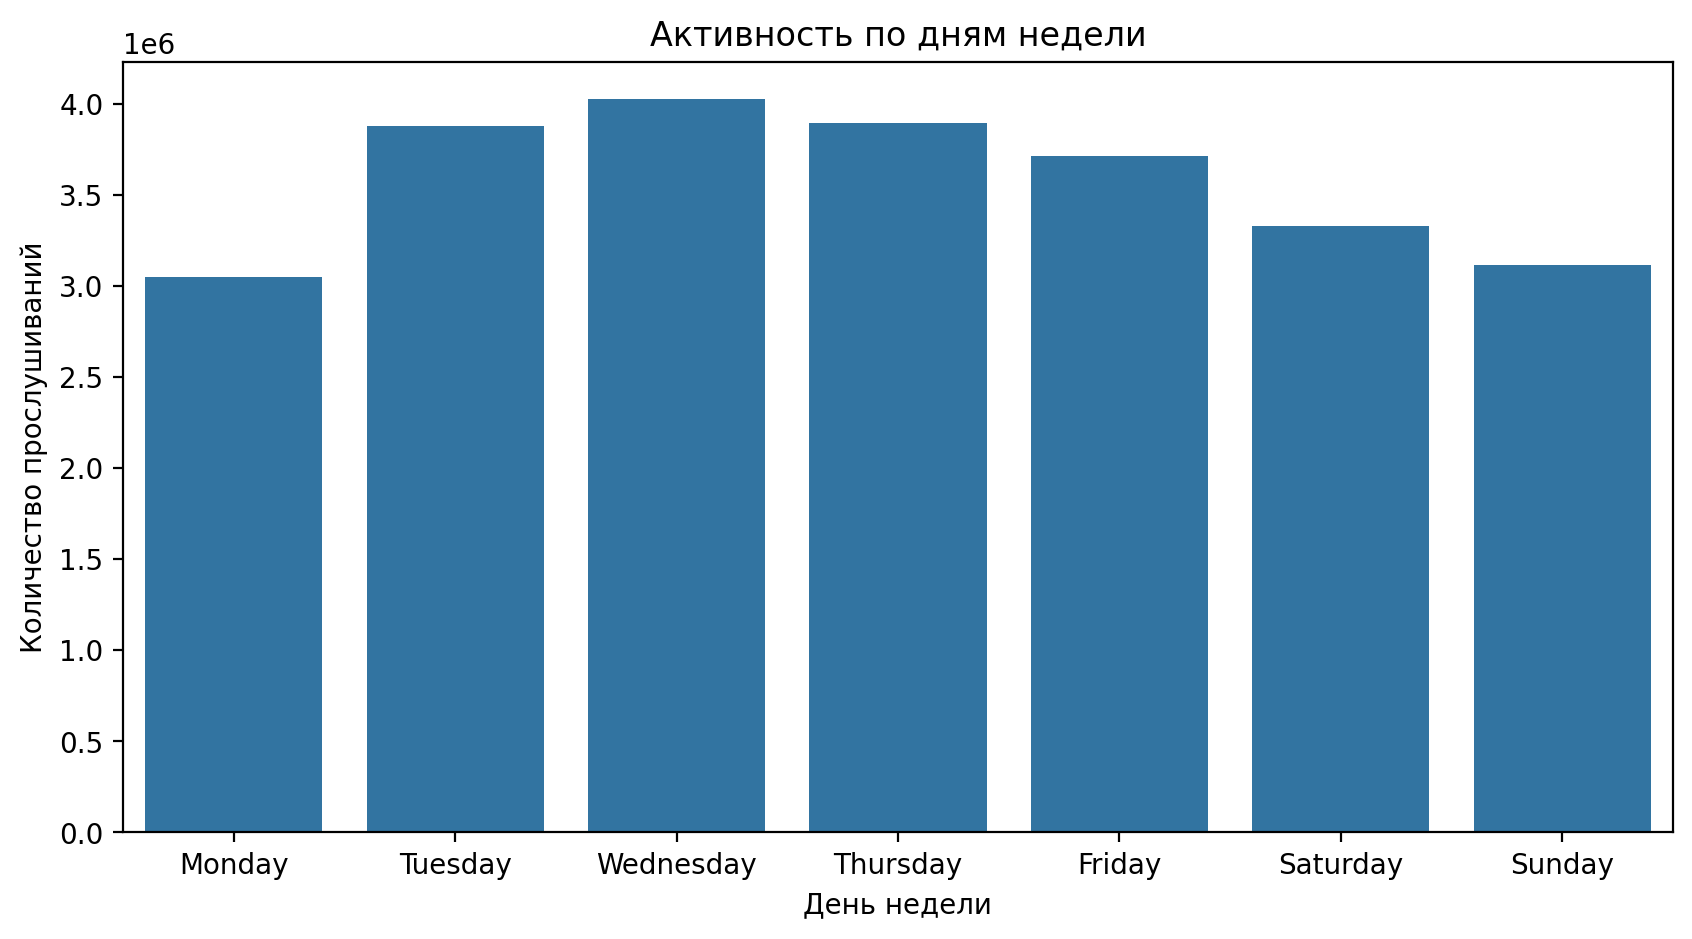

In [ ]:
# Активность пользователей по времени (день недели, час)
# преобразуем в datetime
interactions["started_at"] = pd.to_datetime(interactions["started_at"])

# день недели и час
interactions["weekday"] = interactions["started_at"].dt.day_name()
interactions["hour"] = interactions["started_at"].dt.hour

# распределение по дням недели
plt.figure(figsize=(10, 5))
sns.countplot(x="weekday", data=interactions,
              order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Активность по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество прослушиваний")
plt.savefig("./EDA/interactions_by_time.png")
plt.show()

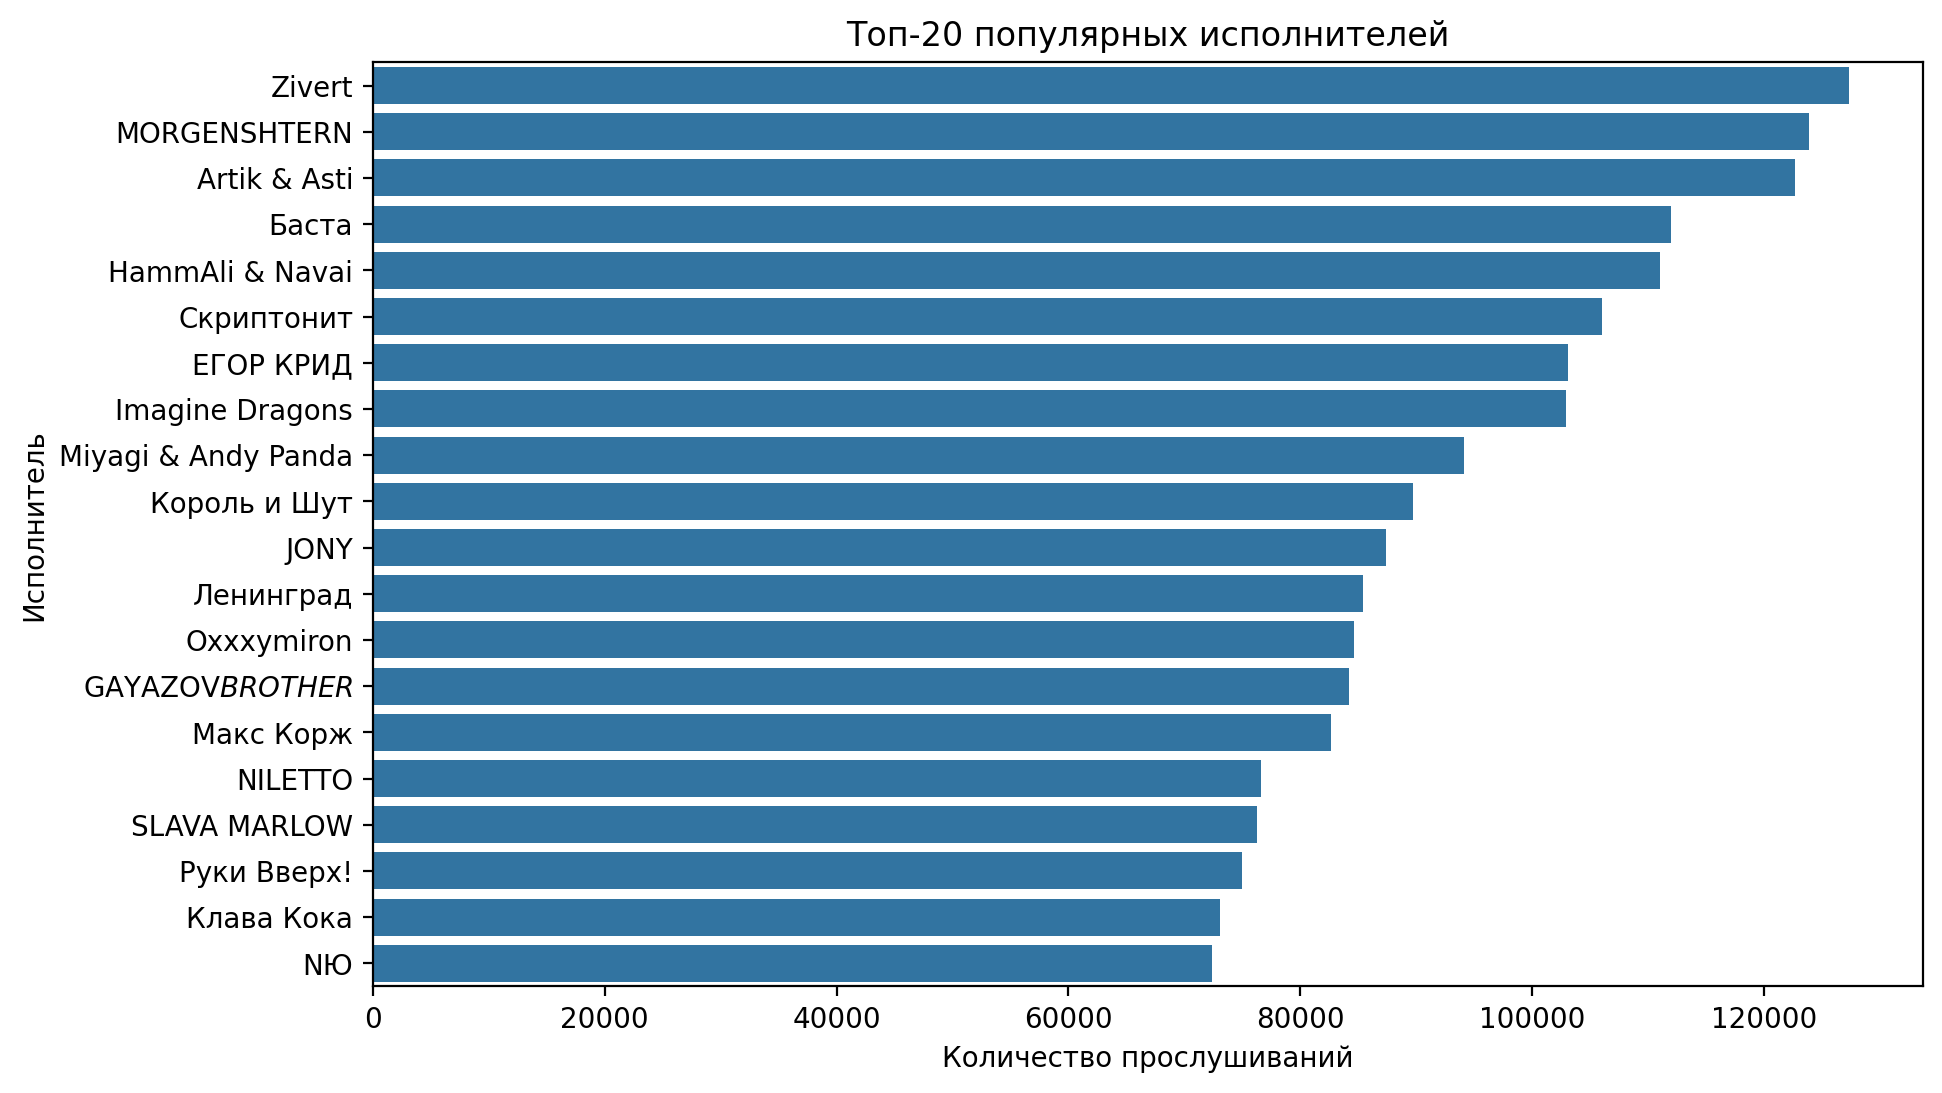

In [ ]:
# популярные исполнители
# развернём список исполнителей
artists_exploded = items_wide[["track_id", "artist_names"]].explode("artist_names")

# объединим с прослушиваниями
interactions_with_artists = interactions.merge(artists_exploded, on="track_id", how="left")

# топ-20 исполнителей
top_artists = interactions_with_artists["artist_names"].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title("Топ-20 популярных исполнителей")
plt.xlabel("Количество прослушиваний")
plt.ylabel("Исполнитель")
plt.savefig("./EDA/top_artists.png")
plt.show()

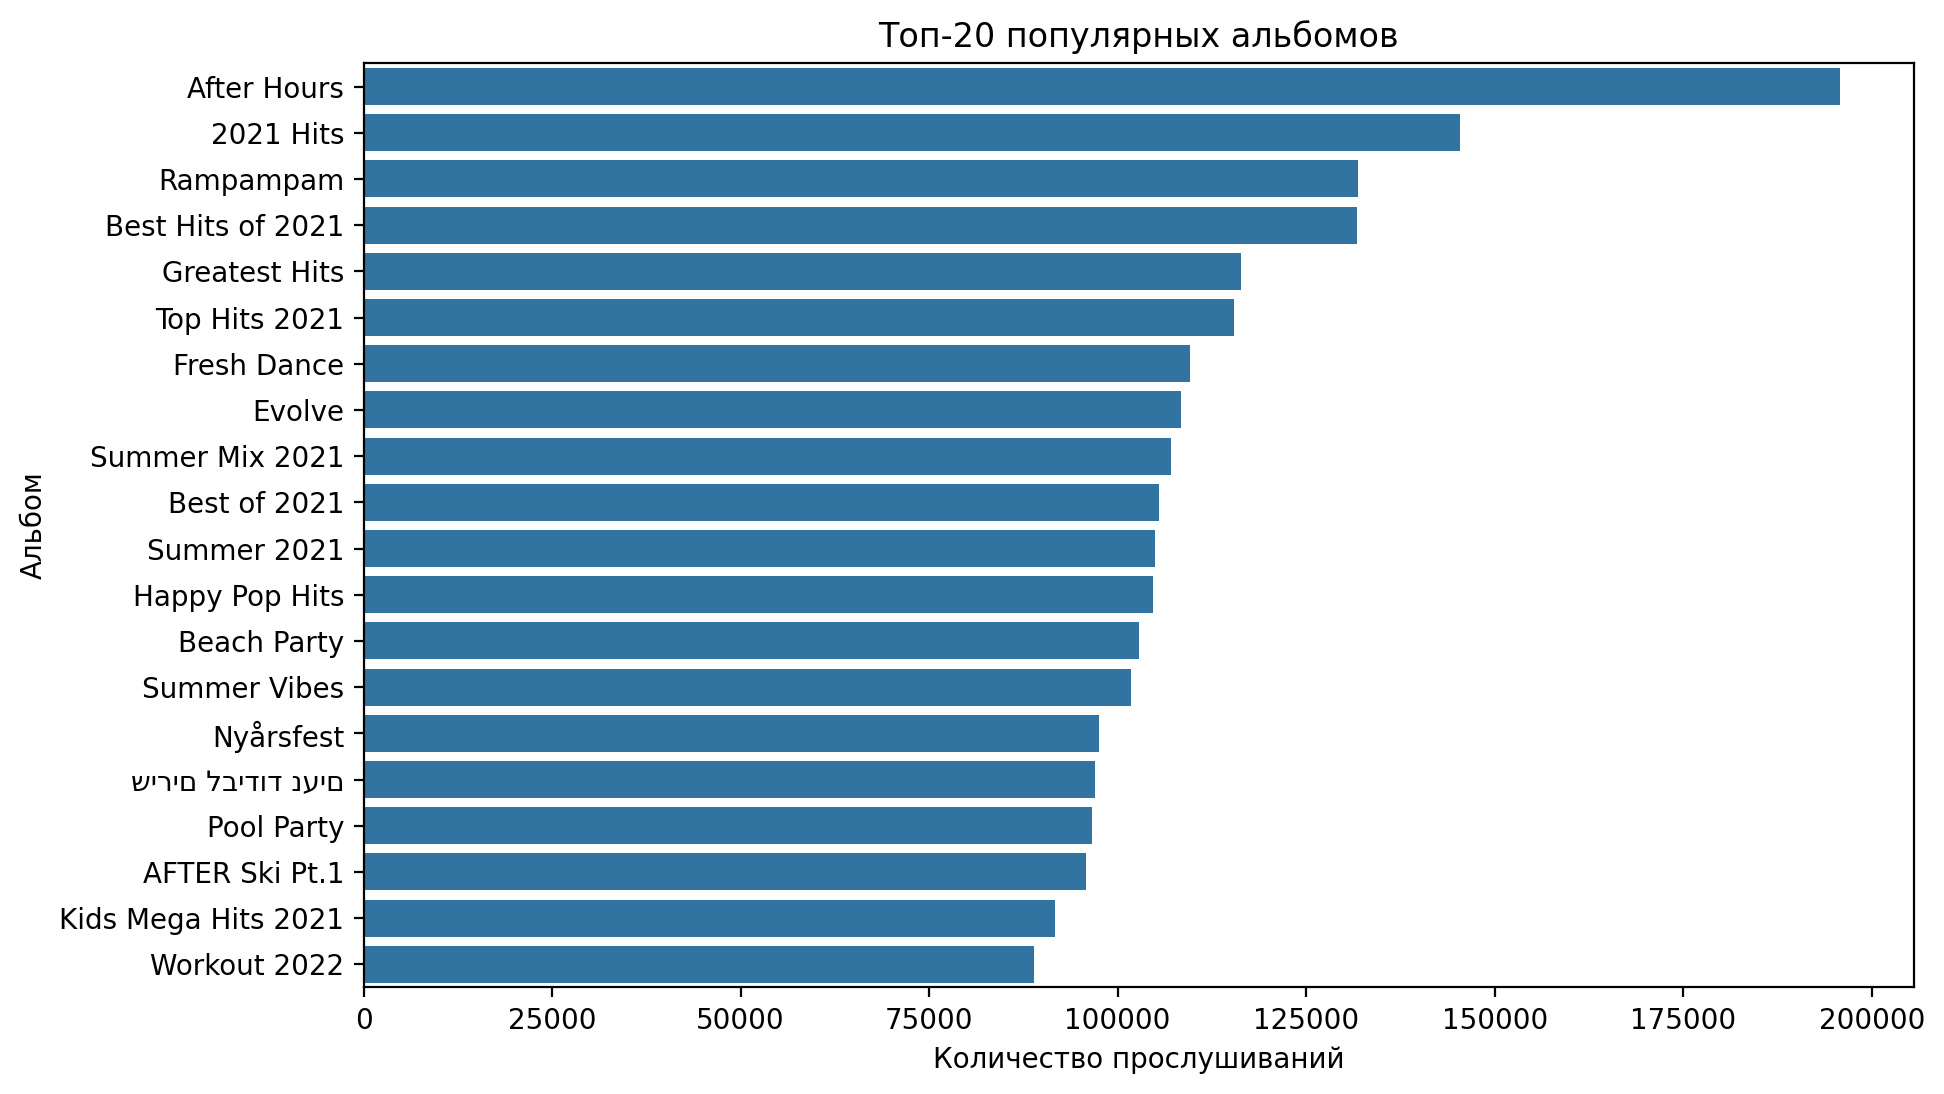

In [ ]:
# популяные альбомы
albums_exploded = items_wide[["track_id", "album_names"]].explode("album_names")
interactions_with_albums = interactions.merge(albums_exploded, on="track_id", how="left")

top_albums = interactions_with_albums["album_names"].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_albums.values, y=top_albums.index)
plt.title("Топ-20 популярных альбомов")
plt.xlabel("Количество прослушиваний")
plt.ylabel("Альбом")
plt.savefig("./EDA/top_albums.png")
plt.show()

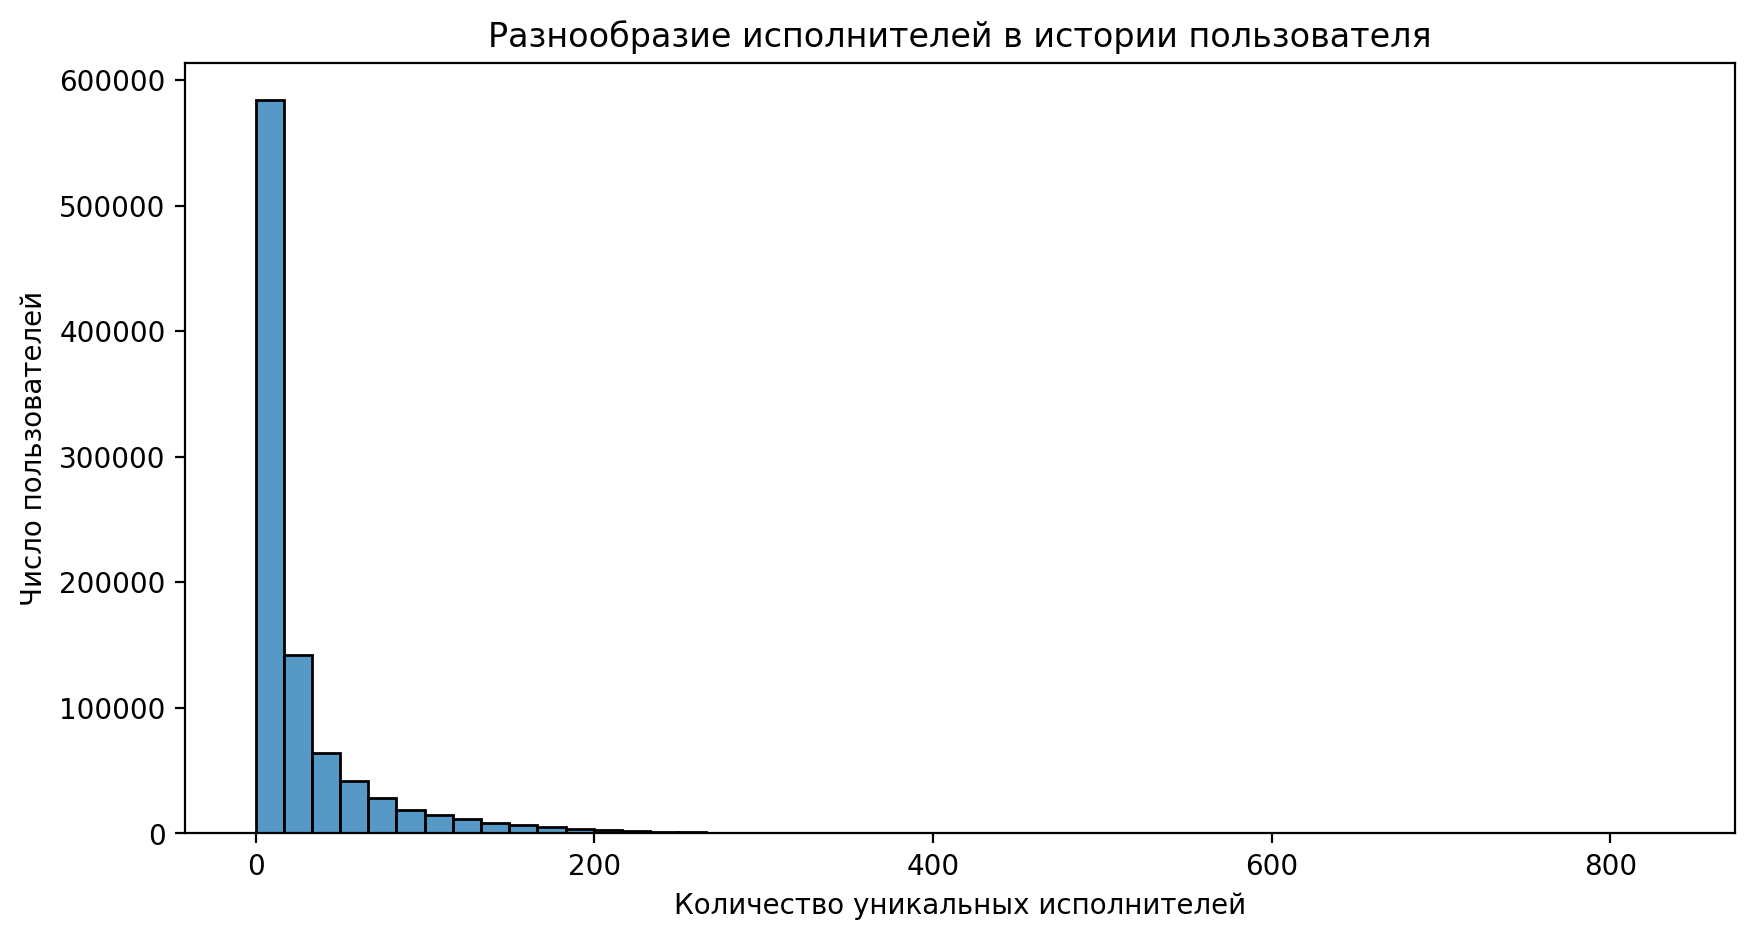

In [ ]:
# Длина истории пользователя (разнообразие жанров/исполнителей)
# количество уникальных исполнителей у каждого пользователя
user_unique_artists = interactions_with_artists.groupby("user_id")["artist_names"].nunique()

plt.figure(figsize=(10, 5))
sns.histplot(user_unique_artists, bins=50)
plt.title("Разнообразие исполнителей в истории пользователя")
plt.xlabel("Количество уникальных исполнителей")
plt.ylabel("Число пользователей")
plt.savefig("./EDA/len_user_history.png")
plt.show()

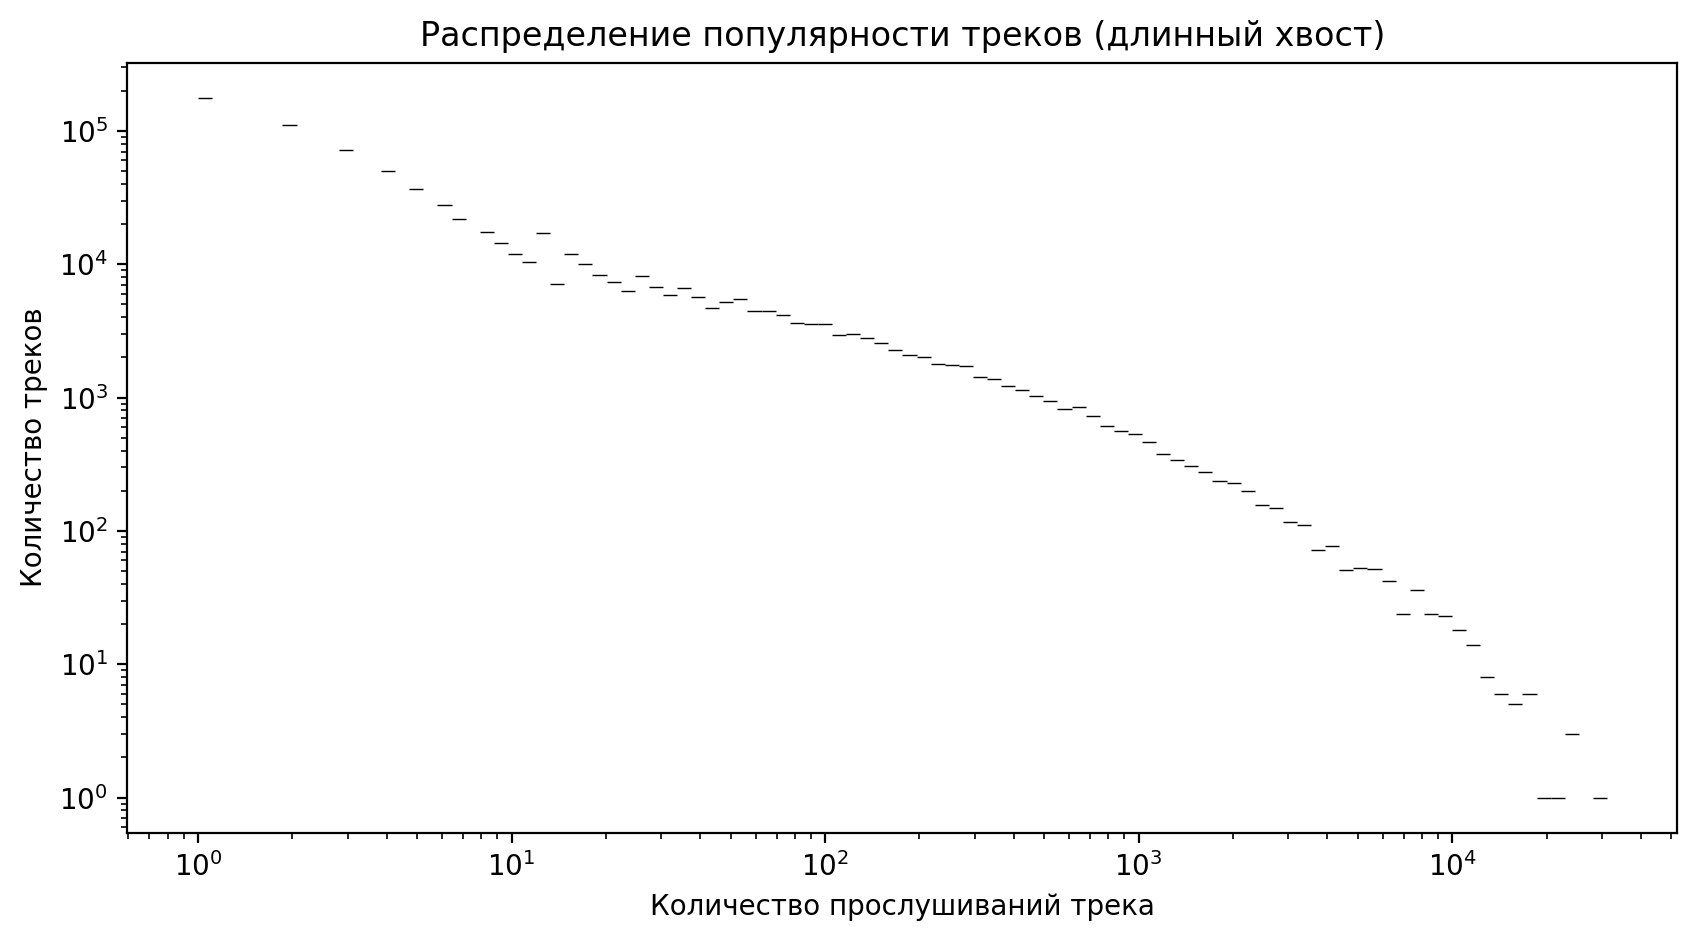

In [ ]:
# “Длинный хвост” треков (частота встречаемости треков)
track_popularity = interactions["track_id"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(track_popularity, bins=100, log_scale=(True, True))  
plt.title("Распределение популярности треков (длинный хвост)")
plt.xlabel("Количество прослушиваний трека")
plt.ylabel("Количество треков")
plt.savefig("./EDA/track_popularity.png")
plt.show()

In [2]:
interactions = pd.read_parquet("./data/interactions.parquet")

In [3]:
# Удаляем полные дубликаты
interactions = interactions.drop_duplicates()

In [4]:
# Приводим типы
interactions["user_id"] = interactions["user_id"].astype(int)
interactions["track_id"] = interactions["track_id"].astype(int)
interactions["track_seq"] = interactions["track_seq"].astype(int)
interactions["started_at"] = pd.to_datetime(interactions["started_at"])

In [ ]:
#Добавляем колонку "вес" (число прослушиваний) ===
# Если есть повторные строки user_id–track_id, то агрегируем => пропадает колонка "track_seq"
interactions["weight"] = 1
interactions = (
    interactions.groupby(["user_id", "track_id"], as_index=False)
    .agg({"weight": "sum", "started_at": "min"})  # можно хранить дату первого прослушивания
)

In [4]:
interactions.head(5)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


# Преобразование данных

#### Данные о треках и прослушиваниях в исходном виде (со списками артистов, жанров, альбомов) ― неудобны для моделей рекомендаций (ALS, LightFM, CatBoost и т.п.), потому что:
- списки в колонках → трудно использовать напрямую;
- нужны числовые и категориальные признаки;
- матрицы взаимодействий пользователей и объектов должны быть разреженными (user–item matrix).

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.
1. Подготовка справочника объектов (items)

In [24]:
# базовый справочник треков
items = tracks.copy()

In [25]:
# добавим названия (по id из catalog_names)
id_name = catalog_names.set_index("id")["name"].to_dict()
id_type = catalog_names.set_index("id")["type"].to_dict()

In [26]:
# отдельные словари
id_album = catalog_names.query("type == 'album'").set_index("id")["name"].to_dict()
id_artist = catalog_names.query("type == 'artist'").set_index("id")["name"].to_dict()
id_genre = catalog_names.query("type == 'genre'").set_index("id")["name"].to_dict()
id_track = catalog_names.query("type == 'track'").set_index("id")["name"].to_dict()

In [27]:
# маппим строго по типу
items["track_name"]   = items["track_id"].map(id_track)
items["album_names"]  = items["albums"].apply(lambda ids: [id_album.get(i, "unknown") for i in ids])
items["artist_names"] = items["artists"].apply(lambda ids: [id_artist.get(i, "unknown") for i in ids])
items["genre_names"]  = items["genres"].apply(lambda ids: [id_genre.get(i, "unknown") for i in ids])

In [28]:
items.head(7)

,track_id,albums,artists,genres,track_name,album_names,artist_names,genre_names
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]
5,139,"[12, 214, 2490809]",[84],[11],Wild Young Hearts,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
6,140,"[12, 214, 2490809]",[84],[11],Sometimes,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]


In [39]:
#### v2

In [32]:
# базовый справочник треков
items = tracks.copy()

# сделаем словари по типам
id2name = {
    (row.id, row.type): row.name
    for row in catalog_names.sort_values(by="type", ascending=False).itertuples()
}
id2track = catalog_names.query("type == 'track'").set_index("id")["name"].to_dict()

In [33]:
def map_ids(ids, type_):
    return [id2name.get((i, type_), "unknown") for i in ids]

In [34]:
# заменяем списки id → списки строк с учётом типа
items["track_name"] = items["track_id"].map(lambda x: id2track.get(x, "unknown"))
items["album_names"]  = items["albums"].apply(lambda ids: map_ids(ids, "album"))
items["artist_names"] = items["artists"].apply(lambda ids: map_ids(ids, "artist"))
items["genre_names"]  = items["genres"].apply(lambda ids: map_ids(ids, "genre"))

In [35]:
items.head(7)

,track_id,albums,artists,genres,track_name,album_names,artist_names,genre_names
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]
5,139,"[12, 214, 2490809]",[84],[11],Wild Young Hearts,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
6,140,"[12, 214, 2490809]",[84],[11],Sometimes,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]


In [ ]:
# "Long"-версия для удобства

In [20]:
# альбомы
albums_long = tracks.explode("albums").rename(columns={"albums": "album_id"})
albums_long["album_name"] = albums_long["album_id"].map(albums_dict)
albums_long.head(2)

,track_id,album_id,artists,genres,album_name
0,26,3,[16],"[11, 21]",Taller Children
0,26,2490753,[16],"[11, 21]",Taller Children


In [21]:
# артисты
artists_long = tracks.explode("artists").rename(columns={"artists": "artist_id"})
artists_long["artist_name"] = artists_long["artist_id"].map(artists_dict)
artists_long.head(2)

,track_id,albums,artist_id,genres,artist_name
0,26,"[3, 2490753]",16,"[11, 21]",Elizabeth & the Catapult
1,38,"[3, 2490753]",16,"[11, 21]",Elizabeth & the Catapult


In [29]:
# жанры
genres_long = tracks.explode("genres").rename(columns={"genres": "genre_id"})
genres_long["genre_name"] = genres_long["genre_id"].map(genres_dict)
genres_long.head(2)

,track_id,albums,artists,genre_id,genre_name
0,26,"[3, 2490753]",[16],11,pop
0,26,"[3, 2490753]",[16],21,folk


In [30]:
# соединяем (по необходимости можно хранить отдельно)
items_long = items[["track_id", "track_name"]].drop_duplicates().merge( #tracks[["track_id"]].drop_duplicates()
    artists_long[["track_id", "artist_id", "artist_name"]], 
    on="track_id", how="left"
).merge(
    albums_long[["track_id", "album_id", "album_name"]],
    on="track_id", how="left"
).merge(
    genres_long[["track_id", "genre_id", "genre_name"]],
    on="track_id", how="left"
)
items_long.head(25)

,track_id,track_name,artist_id,artist_name,album_id,album_name,genre_id,genre_name
0,26,Complimentary Me,16,Elizabeth & the Catapult,3,Taller Children,11,pop
1,26,Complimentary Me,16,Elizabeth & the Catapult,3,Taller Children,21,folk
2,26,Complimentary Me,16,Elizabeth & the Catapult,2490753,Taller Children,11,pop
3,26,Complimentary Me,16,Elizabeth & the Catapult,2490753,Taller Children,21,folk
4,38,Momma's Boy,16,Elizabeth & the Catapult,3,Taller Children,11,pop
5,38,Momma's Boy,16,Elizabeth & the Catapult,3,Taller Children,21,folk
6,38,Momma's Boy,16,Elizabeth & the Catapult,2490753,Taller Children,11,pop
7,38,Momma's Boy,16,Elizabeth & the Catapult,2490753,Taller Children,21,folk
8,135,Atticus,84,Noisettes,12,Wild Young Hearts,11,pop
9,135,Atticus,84,Noisettes,214,Wild Young Hearts,11,pop


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
items_long.to_parquet("./EDA/data/items_wide.parquet")
items.to_parquet("./EDA/data/items.parquet")
interactions.to_parquet("./EDA/data/events.parquet")

In [1]:
import boto3
import os
from dotenv import load_dotenv

In [2]:
# подгружаем .env
load_dotenv(".env")

os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')

In [3]:
class Config:
    AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

    S3_SERVICE_NAME = 's3'
    S3_ENDPOINT_URL = 'https://storage.yandexcloud.net'

In [4]:
def get_session():
    session = boto3.session.Session()

    return session.client(
        service_name=Config.S3_SERVICE_NAME,
        endpoint_url=Config.S3_ENDPOINT_URL,
        aws_access_key_id=Config.AWS_ACCESS_KEY_ID,
        aws_secret_access_key=Config.AWS_SECRET_ACCESS_KEY
    )

bucket_name = 's3-student-mle-20250507-60d03b0a2f-freetrack' 

In [5]:
s3 = get_session()

In [ ]:
s3.upload_file("./EDA/data/events.parquet", bucket_name, "recsys/data/events.parquet")
s3.upload_file("./EDA/data/items.parquet", bucket_name, "recsys/data/items.parquet")
s3.upload_file("./EDA/data/items_wide.parquet", bucket_name, "recsys/data/items_wide.parquet")

In [23]:
if s3.list_objects(Bucket=bucket_name).get('Contents'):
    for key in s3.list_objects(Bucket=bucket_name)['Contents']:
        print(key['Key'])

0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/dataframe/initial_data.csv
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/MLmodel
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/conda.yaml
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/input_example.json
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/python_env.yaml
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/python_model.pkl
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/requirements.txt
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/MLmodel
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/conda.yaml
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/input_example.json
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/python_env.yaml
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/python_model.pkl
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/requirements.txt
1/2979f28bd3fe44259d8043a29295a847/artifacts/cv/
1/2979f28bd3fe44259d8043a29295a847/artifacts/cv/MLmodel
1/2979f28bd3fe44259d804

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
del id_album
del id_artist
del id_genre
del id_track
del albums_long
del artists_long
del genres_long

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
import pandas as pd
import numpy as np

In [3]:
events = pd.read_parquet("./EDA/data/events.parquet")
items = pd.read_parquet("./EDA/data/items.parquet")

In [3]:
items_wide = pd.read_parquet("./EDA/data/items_wide.parquet")

In [81]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   item_id       1000000 non-null  int64 
 1   albums        1000000 non-null  object
 2   artists       1000000 non-null  object
 3   genres        1000000 non-null  object
 4   track_name    1000000 non-null  object
 5   album_names   1000000 non-null  object
 6   artist_names  1000000 non-null  object
 7   genre_names   1000000 non-null  object
dtypes: int64(1), object(7)
memory usage: 61.0+ MB


In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [10]:
events = events.rename(columns={'track_id':'item_id'})
items = items.rename(columns={'track_id':'item_id'})

In [ ]:
items_wide = items_wide.rename(columns={'track_id':'item_id'})

Разбиваем данные на тренировочную и тестовую выборки: в тренировочную отнесите все данные до 16 декабря 2022 года (не включительно).

In [11]:
# зададим точку разбиения
train_test_global_time_split_date = np.datetime64(pd.to_datetime("2022-12-16").date())
train_test_global_time_split_date

numpy.datetime64('2022-12-16')

In [12]:
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
train_test_global_time_split_idx

0       True
1       True
2       True
3       True
4       True
       ...  
287    False
288    False
289    False
290    False
291    False
Name: started_at, Length: 222629898, dtype: bool

In [13]:
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]
events_train.shape, events_test.shape

((208731252, 4), (13898646, 4))

In [14]:
events_train.to_parquet("./EDA/data/events_train.parquet")
events_test.to_parquet("./EDA/data/events_test.parquet")

In [7]:
events_train["started_at"].max(), events_test["started_at"].min()

(Timestamp('2022-12-15 00:00:00'), Timestamp('2022-12-16 00:00:00'))

In [9]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

количество пользователей, которые есть и в train, и в test

In [10]:

common_users = np.intersect1d(events_train["user_id"].unique(), events_test["user_id"].unique())

In [11]:
print(len(users_train), len(users_test), len(common_users)) 

1342566 783525 752870


«Холодные» пользователи — те, которые есть в test, но отсутствуют в train. Это соответствует хронологическому порядку, в котором и работает рекомендательная система.

Идентифицируем холодных пользователей и оценим их количество.

In [12]:
cold_users = events_test.query("user_id not in @common_users")["user_id"].unique()
print(len(cold_users))

30655


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [13]:
from datetime import datetime

In [ ]:
# базовый рейтинг: количество прослушиваний + количество уникальных пользователей
track_stats = (
    events_train.groupby("item_id")
    .agg(
        play_count=("user_id", "count"),
        unique_users=("user_id", "nunique"),
        last_play=("started_at", "max"),
    )
    .reset_index()
)

In [15]:
# нормализация и комбинирование
now = events_train["started_at"].max()
track_stats["recency_days"] = (now - track_stats["last_play"]).dt.days

In [17]:
track_stats

,item_id,play_count,unique_users,last_play,recency_days
0,26,5,5,2022-07-25,143
1,38,8,8,2022-08-25,112
2,135,16,16,2022-08-27,110
3,136,7,7,2022-08-27,110
4,138,17,17,2022-10-04,72
...,...,...,...,...,...
999690,101478482,2,2,2022-11-28,17
999691,101490148,28,28,2022-12-15,0
999692,101493057,4,4,2022-11-30,15
999693,101495927,7,7,2022-12-15,0


In [18]:
# посчитаем рейтинг
# формула рейтинга (пример)
track_stats["rating"] = (
    0.6 * (track_stats["play_count"] / track_stats["play_count"].max()) +
    0.3 * (track_stats["unique_users"] / track_stats["unique_users"].max()) +
    0.1 * (1 - track_stats["recency_days"] / track_stats["recency_days"].max())
)

In [20]:
track_stats

,item_id,play_count,unique_users,last_play,recency_days,rating
0,26,5,5,2022-07-25,143,0.054499
1,38,8,8,2022-08-25,112,0.064397
2,135,16,16,2022-08-27,110,0.065099
3,136,7,7,2022-08-27,110,0.065025
4,138,17,17,2022-10-04,72,0.077209
...,...,...,...,...,...,...
999690,101478482,2,2,2022-11-28,17,0.094602
999691,101490148,28,28,2022-12-15,0,0.100229
999692,101493057,4,4,2022-11-30,15,0.095256
999693,101495927,7,7,2022-12-15,0,0.100057


In [21]:
# добавим названия треков (если есть items)
top_tracks = (
    track_stats
    .merge(items[["item_id", "track_name", "album_names", "artist_names", "genre_names"]], on="item_id", how="left")
)

In [22]:
top_tracks = top_tracks.sort_values("rating", ascending=False)

In [23]:
# выбираем первые 100 айтемов со средней оценкой rating не меньше 4
top_k_pop_items = top_tracks.query("rating > 0.4")[: 100]

In [24]:
# Permanently changes the pandas settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

In [25]:
top_k_pop_items.head(100)

,item_id,play_count,unique_users,last_play,recency_days,rating,track_name,album_names,artist_names,genre_names
9098,53404,110026,110026,2022-12-15,0,1.000000,Smells Like Teen Spirit,"[Nevermind, Nirvana, Nevermind, Nevermind, Nev...",[Nirvana],"[alternative, rock, allrock]"
483876,33311009,101076,101076,2022-12-15,0,0.926790,Believer,"[Shape Of Pop, NOW That's What I Call Music, E...",[Imagine Dragons],"[rock, allrock]"
26665,178529,100866,100866,2022-12-15,0,0.925072,Numb,"[Meteora, Meteora, Meteora, Meteora, 00s Rock ...",[Linkin Park],"[numetal, metal]"
512157,35505245,95523,95523,2022-12-15,0,0.881367,I Got Love,"[I Got Love, I Got Love]","[Miyagi & Эндшпиль, Рем Дигга]","[rusrap, rap]"
368072,24692821,84153,84153,2022-12-15,0,0.788362,Way Down We Go,"[Way down We Go, Summer Music 2016, A/B, DFM D...",[KALEO],[indie]
90461,795836,83749,83749,2022-12-15,0,0.785057,Shape Of My Heart,"[Ten Summoner's Tales, 25 Years, The Best Of 2...",[Sting],"[pop, rock, allrock]"
197265,6705392,80608,80608,2022-12-15,0,0.759364,Seven Nation Army,"[Elephant, Seven Nation Army, Pay Close Attent...",[The White Stripes],[alternative]
475289,32947997,80243,80243,2022-12-15,0,0.756378,Shape of You,"[Shape of You, ÷, ÷, Summer Vibes, Pop]",[Ed Sheeran],[pop]
6558,37384,79512,79512,2022-12-15,0,0.750399,Zombie,"[Stars: The Best Of The Cranberries 1992-2002,...",[The Cranberries],"[rock, allrock]"
647236,45499814,78564,78564,2022-12-15,0,0.742644,Life,"[Life, Life, Made in Russia, Fresh Dance, Life...",[Zivert],"[pop, ruspop]"


In [ ]:
# считаем популярность треков на train - вариант 2
track_popularity = (
    events_train.groupby("item_id")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
# добавим названия треков (если есть items)
top_tracks_v2 = (
    track_popularity
    .merge(items[["item_id", "track_name", "artist_names"]], on="item_id", how="left")
)
print("ТОП-10 популярных треков:")
print(top_tracks_v2.head(10))

- в cold_users_events_with_recs для каждого события получить столбец "rating". В нём при совпадении по "item_id" будет значение из одноимённого столбца из top_k_pop_items, иначе — пропуск.

In [26]:
events_test.shape, events_test[events_test["user_id"].isin(cold_users)].shape

((13898646, 4), (1102359, 4))

In [42]:
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_k_pop_items[["item_id", "rating"]], on="item_id", how="left")

In [43]:
cold_users_events_with_recs.sort_values(by='rating')

,user_id,item_id,track_seq,started_at,rating
677886,849867,68348389,50,2022-12-27,0.486295
907846,1137164,68348389,21,2022-12-26,0.486295
571907,714938,68348389,14,2022-12-26,0.486295
677721,849568,68348389,7,2022-12-27,0.486295
706467,885193,68348389,40,2022-12-25,0.486295
...,...,...,...,...,...
1102354,1374574,86297569,63,2022-12-29,NaN
1102355,1374574,89948063,64,2022-12-29,NaN
1102356,1374574,91791138,65,2022-12-29,NaN
1102357,1374574,92922612,66,2022-12-30,NaN


In [53]:
cold_user_recs = cold_users_events_with_recs.dropna(subset=['rating'])
cold_user_recs.shape

(60832, 5)

In [60]:
# доли событий «холодных» пользователей в events_test рекомендации в top_k_pop_items 
# совпали по трекам?.
fraction = round(len(cold_user_recs)/(len(cold_users_events_with_recs)-len(cold_user_recs)),3)
fraction

0.058

In [61]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("rating", lambda x: (~x.isnull()).mean()))

In [62]:
print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}") 

Доля пользователей без релевантных рекомендаций: 0.43
Среднее покрытие пользователей: 0.10


In [63]:
# сохраняем top_k_pop_items как рекомендации Top 100 для новых пользователей
top_k_pop_items.to_parquet("./recommendations/top_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# загрузка данных, если нужно
events = pd.read_parquet("./EDA/data/events.parquet")

In [4]:
events = events.rename(columns={'track_id':'item_id'})

In [ ]:
events_train = pd.read_parquet("./EDA/data/events_train.parquet")
events_test = pd.read_parquet("./EDA/data/events_test.parquet")

In [2]:
items = pd.read_parquet("./EDA/data/items.parquet")

In [3]:
items = items.rename(columns={'track_id':'item_id'})

#### нужно за основу взять взаимодействия ~1,4 млн пользователей с 1 млн треков:
- Сэмплировать пользователей или треки
- Ограничить по активности — например, оставить только пользователей с ≥5 прослушиваниями и треки, которые слушали ≥10 раз (чтобы убрать «шум»)

сначала проверим на соответсвие, если нет, то опробуем второй путь:
```python
active_users = events["user_id"].value_counts()[lambda x: x >= 5].index
popular_items = events["item_id"].value_counts()[lambda x: x >= 10].index

events_filtered = events[events["user_id"].isin(active_users) & events["item_id"].isin(popular_items)]
```

In [5]:
# проверим соответствие датасета требованиям и оценим степень разреженности U-I-матрицы, построенной на основе events. 
n_users = events["user_id"].nunique()
n_items = events["item_id"].nunique()
n_rating = len(events)
print(f"кол-во пользователей: {n_users}, кол-во треков: {n_items}")
print(f"Всего взаимодействий: {n_rating:,}")

кол-во пользователей: 1373221, кол-во треков: 1000000
Всего взаимодействий: 222,629,898


- Вывод: датасет соответствует

In [5]:
events["started_at"].min(), events["started_at"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [6]:
# Разреженность
sparsity = (1 - n_rating/(n_users * n_items))*100
print(f"Разреженность U-I матрицы: {sparsity}")

Разреженность U-I матрицы: 99.98378775899873


#### Получаем матрицу для LAS и обучаем модель - вариант 1:

Для ALS нам нужна «оценка» — насколько сильно пользователь взаимодействовал с треком.
В музыке обычно берут количество прослушиваний (playcount).

In [9]:
user_track_interactions = (
    events_train
    .groupby(["user_id", "item_id"])
    .size()   # количество прослушиваний
    .reset_index(name="playcount")
)

Добавим названия треков, чтобы можно было интерпретировать результаты.

In [8]:
user_track_interactions = user_track_interactions.merge(
    items[["item_id", "track_name"]], on="item_id", how="left"
)

Индексация для ALS, implicit (и аналогичные библиотеки) требуют целые индексы вместо user_id и item_id.

In [10]:
import scipy
import sklearn.preprocessing

In [11]:
user_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder = sklearn.preprocessing.LabelEncoder()

user_track_interactions["user_id_enc"] = user_encoder.fit_transform(user_track_interactions["user_id"])
user_track_interactions["item_id_enc"] = item_encoder.fit_transform(user_track_interactions["item_id"])

Получаем разреженную матрицу для ALS (первый вариант)

In [13]:
rows = user_track_interactions["user_id_enc"].values
cols = user_track_interactions["item_id_enc"].values
data = user_track_interactions["playcount"].values

user_item_csr = scipy.sparse.csr_matrix((data, (rows, cols)))

In [14]:
# сохраним на диск, дабы не пересчитывать каждый раз, когда ВМ падает
from scipy import sparse
sparse.save_npz("./models/user_item_csr_playcount.npz", user_item_csr)

In [28]:
# сразу пишем когд для ее загрузки
from scipy import sparse
user_item_csr = sparse.load_npz("./models/user_item_csr_playcount.npz")

- Имея подготовленную матрицу взаимодействий, перейдём к третьему шагу — создадим ALS-модель. Для примера возьмём количество латентных факторов для матриц $P, Q$, равным 50. 

In [15]:
from implicit.als import AlternatingLeastSquares

als_model_v1 = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model_v1.fit(user_item_csr) 

/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
import pickle

In [19]:
# сохраняем модель
als_model_v1.save("./models/als_model_v1.npz")

# сохраняем маппинги
with open("./models/mappings_v1.pkl", "wb") as f:
    pickle.dump({"rows": rows,"cols": cols, "data":data}, f)

In [4]:
# Загружаем модель если нужно
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares()
als_model = als_model.load("./models/als_model_v1.npz")

/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [ ]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations_v1 = als_model_v1.recommend(
    user_ids_encoded, 
    user_item_csr[user_ids_encoded], 
    filter_already_liked_items=False, N=100) 

In [ ]:
item_ids_enc = als_recommendations_v1[0]
als_scores = als_recommendations_v1[1]

In [ ]:
# сохранение
with open('item_ids_enc.npy', 'wb') as f:
    np.save(f, item_ids_enc)
with open('als_scores.npy', 'wb') as f:
    np.save(f, als_scores)    

In [12]:
# загрузка
item_ids_enc = np.load('item_ids_enc.npy')
als_scores = np.load('als_scores.npy')

In [14]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])

LabelEncoder()

In [13]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))


In [14]:
user_ids_encoded, len(item_ids_enc), len(als_scores)

(range(0, 1342566), 1342566, 1342566)

In [ ]:
del events
del events_test
del events_train
del items

In [ ]:
# преобразуем полученные рекомендации в табличный формат
#item_ids_enc = als_recommendations[0]
#als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})

In [3]:
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

In [16]:
# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

In [17]:
# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"]) 

In [18]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("./recommendations/personal_als.parquet")

Получаем разреженную матрицу для ALS (второй вариант)

In [14]:
# user_id и track_id → для матрицы взаимодействий
user_ids = events["user_id"].unique()
track_ids = events["item_id"].unique()

In [ ]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [ ]:
# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

Получим разреженную матрицу для ALS вторым способом

In [16]:
# строим матрицу пользователь × трек
rows = events_train["user_id_enc"].to_numpy()
cols = events_train["item_id_enc"].to_numpy()

In [18]:
events_train.head()

,user_id,item_id,track_seq,started_at,user_id_enc,item_id_enc
0,0,99262,1,2022-07-17,0,16078
1,0,589498,2,2022-07-19,0,60661
2,0,590262,3,2022-07-21,0,61135
3,0,590303,4,2022-07-22,0,61158
4,0,590692,5,2022-07-22,0,61386


In [ ]:
#data = np.ones(len(events_train))  # бинарные прослушивания
user_item_matrix_train = scipy.sparse.csr_matrix(
    (data, (rows, cols)), 
    shape=(len(user_ids), len(track_ids)),
    dtype=np.int8
    )

In [18]:
# сохраним на диск, дабы не пересчитывать каждый раз, когда ВМ падает
from scipy import sparse
sparse.save_npz("./models/user_item_matrix_train.npz", user_item_matrix_train)

In [ ]:
# сразу пишем код для ее загрузки
from scipy import sparse
user_item_matrix_train = sparse.load_npz("./models/user_item_matrix_train.npz")

- Имея подготовленную матрицу взаимодействий, перейдём к третьему шагу — создадим ALS-модель. Для примера возьмём количество латентных факторов для матриц $P, Q$, равным 50. 

In [ ]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train) 

In [10]:
import pickle

In [ ]:
# сохраняем модель
als_model.save("./models/als_model.npz")

# сохраняем маппинги
with open("./models/mappings.pkl", "wb") as f:
    pickle.dump({"user_ids": user_ids,"track_ids": track_ids}, f)

In [6]:
# Загружаем модель если нужно
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares()
als_model = als_model.load("./models/als_model.npz")

/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [15]:
user_item_matrix_train

<1373221x1000000 sparse matrix of type '<class 'numpy.float64'>'
	with 208731252 stored elements in Compressed Sparse Row format>

In [ ]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100) 

In [ ]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"]) 

- Сохраним полученные рекомендации в файл, они ещё нам пригодятся.

In [ ]:
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("./recommendations/personal_als.parquet")

- Чтобы получить рекомендации для пользователя с помощью модели ALS, используем такую функцию:

In [19]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
        user_id_enc, 
        user_item_matrix[user_id_enc], 
        filter_already_liked_items=not include_seen,
        N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations 

In [26]:
items.head(3)

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]


In [36]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["track_name", "album_names", "artist_names", "genre_names"]], on="item_id")
)
user_history_to_print = user_history[["track_name", "album_names", "artist_names", "genre_names"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_als(user_item_csr, als_model, user_id, user_encoder, item_encoder, include_seen=True, n=5)
user_recommendations = user_recommendations.merge(items[["item_id","track_name", "album_names", "artist_names", "genre_names"]], on="item_id")
display(user_recommendations)

user_id: 1350000
История (последние события, recent)


,track_name,album_names,artist_names,genre_names
707,Не выводи меня,[Малолетки],"[МУККА, Три дня дождя]","[rusrock, allrock]"
708,13 карт - Цитаты великих людей,[13 карт - Цитаты великих людей],[Студия Феникс],[pop]
709,НЕ ХОЧУ БОЛЬШЕ ПЛАКАТЬ,[НЕ ХОЧУ БОЛЬШЕ ПЛАКАТЬ],[20TOKENS],[alternative]
710,Мы слишком разные,[Мы слишком разные],"[Grechanik, Абрикоса]","[pop, ruspop]"
711,Сабрина,[Сабрина],[MIKAYA],"[rusrock, allrock]"
712,Мужчины круче,[Мужчины круче],[Остап Парфёнов],"[rusrap, rap]"
713,Dance,[Dance],[Aiscoot],"[pop, ruspop]"
714,Ночь,[Ночь],[CHEBANOV],"[pop, ruspop]"
715,Целуй,[Целуй],[kavabanga Depo kolibri],"[pop, ruspop]"
716,Она тебя любит,[Она тебя любит],"[SLAVA MARLOW, The Limba, Элджей]","[rusrap, rap]"


Рекомендации


,item_id_enc,score,item_id,track_name,album_names,artist_names,genre_names
0,289481,0.604340,18385776,Freaks,"[Freaks, Freaks, Metro FM Dance Hits 2015, Тан...","[Timmy Trumpet, Savage]","[dance, electronics, house]"
1,539360,0.598923,37258117,Я так соскучился,"[В диапазоне между отчаянием и надеждой, Панки...",[Порнофильмы],[punk]
2,668077,0.588551,47627256,Cradles,"[Cradles, Cradles]",[Sub Urban],[electronics]
3,686926,0.582081,50400505,Девочка с каре,[Девочка с каре],[МУККА],"[rusrock, allrock]"
4,751875,0.522607,57185718,Молчи,[Магазин игрушек для взрослых],[кис-кис],[punk]


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

#### Рекомендации I2I
Рекомендации вида I2I — это рекомендации похожих объектов. Например, к некоторому треку порекомендовать плэйлист похожих треков. Рассматриваемая реализация ALS позволяет получить такие рекомендации при помощи метода similar_items.

In [5]:
import sklearn.metrics
import implicit
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [6]:
# загрузка данных, если нужно
events_train = pd.read_parquet("./EDA/data/events_train.parquet")
items = pd.read_parquet("./EDA/data/items.parquet")
items = items.rename(columns={'track_id':'item_id'})

In [7]:
# Загружаем модель если нужно
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares()
als_model = als_model.load("./models/als_model_v1.npz")

/home/mle-user/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Нам нужна «оценка» — насколько сильно пользователь взаимодействовал с треком.
В музыке обычно берут количество прослушиваний (playcount).

In [5]:
user_track_interactions = (
    events_train
    .groupby(["user_id", "item_id"])
    .size()   # количество прослушиваний
    .reset_index(name="playcount")
)
user_track_interactions = user_track_interactions.merge(
    items[["item_id", "track_name", "album_names", "artist_names", "genre_names"]], on="item_id", how="left"
)

In [6]:
user_track_interactions.head()

,user_id,item_id,playcount,track_name,album_names,artist_names,genre_names
0,0,99262,1,Bad Bad Boys,"[Midi, Maxi & Efti, Svenska 90-talshits]","[Midi, Maxi & Efti]",[pop]
1,0,589498,1,"Чао, бамбино",[Car-Mania],[Кар-Мэн],"[pop, ruspop]"
2,0,590262,1,Бомбей буги,"[Car-Mania, «Физрук»]",[Кар-Мэн],"[pop, ruspop]"
3,0,590303,1,Bad Russians,"[Car-Mania, «Физрук»]",[Кар-Мэн],"[pop, ruspop]"
4,0,590692,1,Великий инквизитор,"[Русская массированная звуковая агрессия, «Физ...",[Кар-Мэн],"[pop, ruspop]"


In [8]:
import scipy
import sklearn.preprocessing

In [ ]:
user_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder = sklearn.preprocessing.LabelEncoder()

user_track_interactions["user_id_enc"] = user_encoder.fit_transform(user_track_interactions["user_id"])
user_track_interactions["item_id_enc"] = item_encoder.fit_transform(user_track_interactions["item_id"])

In [9]:
item_encoder = sklearn.preprocessing.LabelEncoder()

In [10]:
items["item_id_enc"] = item_encoder.fit_transform(items["item_id"])

Используя метод  similar_items, получим и оценим рекомендации для нескольких айтемов.

In [12]:
# выберем несколько айтемов, для которых хотим получить рекомендации
item_ids = []
for i in range(1,4):
    item_ids.append(user_track_interactions['item_id_enc'].sample().iat[0])

# получим похожие айтемы для каждого
for item_id in item_ids:
    similar = als_model.similar_items(item_id, N=5)  # топ-5 похожих
    print(f'\nТрэк\n {items[["item_id", "track_name", "album_names", "artist_names", "genre_names"]].loc[items["item_id_enc"] == item_id].to_string()}:')
    sim_item = similar[0]
    print('sim_item: ', sim_item)
    print(type(sim_item))
    score = similar[1]
    print('score: ', score)
    display(items[["item_id", "track_name", "album_names", "artist_names", "genre_names"]].loc[items["item_id_enc"].isin(sim_item)])


Трэк
          item_id    track_name     album_names artist_names            genre_names
934532  81555882  Take Me Away  [Take Me Away]      [Omnia]  [electronics, trance]:
sim_item:  [934532 463388 960317 950322 913775]
<class 'numpy.ndarray'>
score:  [1.0000001 0.9721392 0.9675111 0.9604404 0.9559114]


,item_id,track_name,album_names,artist_names,genre_names
463388,32302538,Hey Maria,"[Hey Maria, Hey Maria - EP, Balearic Beats, Ba...","[Klangkarussell, Elderbrook]",[dance]
913775,77924114,Somebody That I Used To Know,[Somebody That I Used To Know],"[Farizki, Orfeo]",[electronics]
934532,81555882,Take Me Away,[Take Me Away],[Omnia],"[electronics, trance]"
950322,85358515,Love Me,[88],[Spoob],"[foreignrap, rap]"
960317,88005482,Where Do I Go?,[Where Do I Go?],[Austin Farwell],[relax]



Трэк
          item_id             track_name                                              album_names artist_names         genre_names
562300  38634577  Место для шага вперёд  [Звезда по имени Солнце, Легенда, Лето (Песня для Цоя)]       [КИНО]  [rusrock, allrock]:
sim_item:  [562300 562296 562238 562230 562224]
<class 'numpy.ndarray'>
score:  [1.0000001  0.9911461  0.9878227  0.97898656 0.97592103]


,item_id,track_name,album_names,artist_names,genre_names
562224,38633703,Niech Żyję Wolność i Swoboda,[25 Lat],"[Boys, Sky Dee Joy]","[pop, disco]"
562230,38633711,Последний герой,"[Последний герой, Легенда]",[КИНО],"[rusrock, allrock]"
562238,38633759,Звезда,"[Чёрный альбом, Легенда]",[КИНО],"[rusrock, allrock]"
562296,38634572,Песня без слов,"[Звезда по имени Солнце, Легенда]",[КИНО],"[rusrock, allrock]"
562300,38634577,Место для шага вперёд,"[Звезда по имени Солнце, Легенда, Лето (Песня ...",[КИНО],"[rusrock, allrock]"



Трэк
          item_id track_name album_names artist_names         genre_names
278331  17563777  Я с тобой    [Лучшие]      [Звери]  [rusrock, allrock]:
sim_item:  [278331 400063 278319 278288 278324]
<class 'numpy.ndarray'>
score:  [1.0000001  0.9553612  0.92374164 0.92034155 0.90514666]


,item_id,track_name,album_names,artist_names,genre_names
278288,17563734,Я с тобой,[Дальше],[Звери],"[rusrock, allrock]"
278319,17563765,Никуда не надо,[Лучшие],[Звери],"[rusrock, allrock]"
278324,17563770,Южная ночь,[Лучшие],[Звери],"[rusrock, allrock]"
278331,17563777,Я с тобой,[Лучшие],[Звери],"[rusrock, allrock]"
400063,27212628,Ты так прекрасна,"[Страха нет, Ты так прекрасна]",[Звери],"[rusrock, allrock]"


Используя метод  similar_users, получим и оценим рекомендации для нескольких users.

In [18]:
# выберем несколько айтемов, для которых хотим получить рекомендации
user_ids = []
for i in range(1,4):
    user_ids.append(user_track_interactions['user_id_enc'].sample().iat[0])

# получим похожие айтемы для каждого
for user_id in user_ids:
    similar = als_model.similar_users(user_id, N=5)  # топ-5 похожих
    item = user_track_interactions[["item_id"]].loc[user_track_interactions["user_id_enc"]==user_id]
    print(f'Для пользователя: {user_id} c треками:')
    #print('item: ', item["item_id"].head(5))
    print('\nТреки\n:')
    display(items[["item_id", "track_name", "album_names", "artist_names", "genre_names"]].loc[items["item_id"].isin(item["item_id"])].head(5))
    sim_users = similar[0]
    print('sim_item: ', sim_users)
    score = similar[1]
    print('score: ', score)
    item_recomend = user_track_interactions[["item_id"]].loc[user_track_interactions["user_id_enc"].isin(sim_users)]
    print('\nТреки рекомендованы\n :')
    display(items[["item_id", "track_name", "album_names", "artist_names", "genre_names"]].loc[items["item_id"].isin(item_recomend["item_id"])])
    #print(items[["item_id", "author", "title", "genre_and_votes"]].loc[items["item_id_enc"].isin(sim_item)])

Для пользователя: 126160 c треками:

Треки
:


,item_id,track_name,album_names,artist_names,genre_names
1535,7785,In The Morning,[Rock Hits Workout 60 - 145 - 90bpm Ideal For ...,[Razorlight],"[rock, allrock]"
9613,57721,Sad But True,[Metallica],[Metallica],"[classicmetal, metal]"
9978,60119,Turn the Page,[Garage Inc.],[Metallica],"[classicmetal, metal]"
15371,93673,In The Air Tonight,[The Hangover - Original Motion Picture Soundt...,[Phil Collins],"[pop, relax]"
16527,103782,Kung Fu Fighting,"[Cool - One Hit Wonders, Cool - Pop, Hits For ...",[Carl Douglas],"[soul, rnb]"


sim_item:  [126160 759259  54744 373879 838960]
score:  [1.         0.7505511  0.7329216  0.72274023 0.722666  ]

Треки рекомендованы
 :


,item_id,track_name,album_names,artist_names,genre_names
108,986,Fortunate Son,"[Chronicle: 20 Greatest Hits, More Creedence G...",[Creedence Clearwater Revival],"[rock, allrock]"
1519,7573,The Switch,"[Planet Funk, Planet Funk, Non Zero Sumness, N...",[Planet Funk],[electronics]
1535,7785,In The Morning,[Rock Hits Workout 60 - 145 - 90bpm Ideal For ...,[Razorlight],"[rock, allrock]"
1616,8264,Paper Planes,[Slumdog Millionaire - Music From The Motion P...,[M.I.A.],"[electronics, unknown]"
1966,9769,I Was Made For Lovin' You,"[Playlist Plus, Dynasty, Greatest Kiss, Gold (...",[Kiss],"[rock, hardrock, allrock]"
...,...,...,...,...,...
978511,92584916,Опять дожди,"[Опять дожди, Опять дожди, DUSHEVNIJ]","[Кравц, Гио Пика]","[rusrap, rap]"
980395,93126179,Солнце Монако,[The End],[Люся Чеботина],"[pop, ruspop]"
986811,95070082,По-другому,[По-другому],"[Лолита, Коста Лакоста]","[pop, ruspop]"
988388,95565189,Твои глаза,[Твои глаза],[polnalyubvi],"[pop, ruspop]"


Для пользователя: 801239 c треками:

Треки
:


,item_id,track_name,album_names,artist_names,genre_names
158,1105,I'll Make Love To You,"[Motown Love, Motown Love, 90s Soul, Motown #1...",[Boyz II Men],[rnb]
170,1121,End Of The Road,"[Motown Love, Motown Love, End Of The Road Hit...",[Boyz II Men],[rnb]
188,1167,My Mom,"[Relapse, Relapse: Refill, Relapse: Refill, Re...",[Eminem],"[foreignrap, rap]"
189,1168,Deja Vu,"[Relapse, Relapse: Refill, Relapse: Refill, Re...",[Eminem],"[foreignrap, rap]"
190,1169,Insane,"[Relapse, Relapse: Refill, Relapse: Refill, Re...",[Eminem],"[foreignrap, rap]"


sim_item:  [ 801239  486258 1325571  937205   49407]
score:  [0.9999999  0.71501255 0.7090527  0.68728405 0.68162864]

Треки рекомендованы
 :


,item_id,track_name,album_names,artist_names,genre_names
54,562,I Gotta Feeling,"[THE E.N.D. (THE ENERGY NEVER DIES), THE E.N.D...",[Black Eyed Peas],"[pop, electronics]"
158,1105,I'll Make Love To You,"[Motown Love, Motown Love, 90s Soul, Motown #1...",[Boyz II Men],[rnb]
170,1121,End Of The Road,"[Motown Love, Motown Love, End Of The Road Hit...",[Boyz II Men],[rnb]
188,1167,My Mom,"[Relapse, Relapse: Refill, Relapse: Refill, Re...",[Eminem],"[foreignrap, rap]"
189,1168,Deja Vu,"[Relapse, Relapse: Refill, Relapse: Refill, Re...",[Eminem],"[foreignrap, rap]"
...,...,...,...,...,...
883039,72737512,Быстро,[АРТЁМ],"[SLAVA MARLOW, MORGENSHTERN]","[rusrap, rap]"
884602,72920590,Многоточия,[Многоточия],[Zivert],"[pop, ruspop]"
886236,73151473,Запомни I love you,[Запомни I love you],"[SHAMI, Rauf & Faik]","[pop, ruspop]"
887453,73298507,Осень пьяная,[Осень пьяная],[Дора],"[local-indie, indie]"


Для пользователя: 545482 c треками:

Треки
:


,item_id,track_name,album_names,artist_names,genre_names
79,861,Long Tall Sally,"[Good Golly!, Specialty Profiles: Roy Milton, ...",[Little Richard],"[rock, blues, rnb, allrock]"
108,986,Fortunate Son,"[Chronicle: 20 Greatest Hits, More Creedence G...",[Creedence Clearwater Revival],"[rock, allrock]"
441,2170,I Want You Back,"[Diana Ross Presents The Jackson 5, Icons: Jac...",[The Jackson 5],"[pop, rnb]"
476,2367,War,"[War And Peace, Motown #1's, Lost And Found: P...",[Edwin Starr],[pop]
1154,5414,Need A Boss,[Def Jam 25: Volume 4 - It Takes Two Pt. 2],"[Shareefa, Ludacris]","[foreignrap, rap]"


sim_item:  [ 545482  150351 1299039 1253523 1148313]
score:  [1.0000001  0.8018842  0.7798253  0.76860195 0.7541982 ]

Треки рекомендованы
 :


,item_id,track_name,album_names,artist_names,genre_names
79,861,Long Tall Sally,"[Good Golly!, Specialty Profiles: Roy Milton, ...",[Little Richard],"[rock, blues, rnb, allrock]"
108,986,Fortunate Son,"[Chronicle: 20 Greatest Hits, More Creedence G...",[Creedence Clearwater Revival],"[rock, allrock]"
206,1185,Crack A Bottle,"[Relapse, Relapse: Refill, Relapse: Refill, Re...","[Eminem, Dr. Dre, 50 Cent]","[foreignrap, rap]"
441,2170,I Want You Back,"[Diana Ross Presents The Jackson 5, Icons: Jac...",[The Jackson 5],"[pop, rnb]"
476,2367,War,"[War And Peace, Motown #1's, Lost And Found: P...",[Edwin Starr],[pop]
...,...,...,...,...,...
988088,95463168,Just The Two of Us,[Just The Two of Us],"[Kauai45, Sweet Cocoa]","[soul, rnb]"
991356,96668273,Favorite Tings,[Favorite Tings],[Masego],[rnb]
992079,96920149,Number Six,[Number Six],"[Namadzu, Satxri]","[foreignrap, rap]"
992772,97220732,The Fall,"[The Fall, Technoblues Therapy (Part I)]","[Intelligency, BAGEW]",[dance]


Получим похожести для всех треков

In [11]:
item_ids = items["item_id_enc"].astype("category")

In [ ]:
# 4. Генерируем i2i рекомендации (ч.1 для первой половины каталога)
similar_items = []

for i, item_id in enumerate(item_ids.cat.categories):
    if i == 500000:
        break
    sims = als_model.similar_items(item_id, N=6)  # 1 + 5 (включая сам трек)
    sim_items = sims[0]
    score = sims[1]
    for j, score in zip(sim_items, score):
        if j == i:  # пропускаем сам item
            continue
        similar_items.append({
            "item_id_1": item_id,
            "item_id_2": item_ids.cat.categories[j],
            "score": float(score)
        })

similar_items_df = pd.DataFrame(similar_items)

# 5. Сохраняем в parquet
similar_items_df.to_parquet("./recommendations/similar_1.parquet", index=False)

print(similar_items_df.head(10))
print(f"Готово: {len(similar_items_df):,} пар сохранено в similar.parquet")

   item_id_1  item_id_2     score
0          0     309734  0.840418
1          0     389978  0.821281
2          0     337440  0.817329
3          0     384734  0.805600
4          0     103329  0.800977
5          1     291225  0.796976
6          1     430818  0.796959
7          1     379567  0.795883
8          1     220578  0.792648
9          1     169669  0.787348
Готово: 2,500,504 пар сохранено в similar.parquet


In [ ]:
# Генерируем i2i рекомендации (ч.2 для второй половины каталога)
similar_items = []

for i, item_id in enumerate(item_ids.cat.categories):
    if i >= 500000:
        try:
            sims = als_model.similar_items(item_id, N=6)  # 1 + 5 (включая сам трек)
            sim_items = sims[0]
            score = sims[1]
            for j, score in zip(sim_items, score):
                if j == i:  # пропускаем сам item
                    continue
                similar_items.append({
                    "item_id_1": item_id,
                    "item_id_2": item_ids.cat.categories[j],
                    "score": float(score)
                })
        except Exception as e:
            print(e)

similar_items_df = pd.DataFrame(similar_items)

# 5. Сохраняем в parquet
similar_items_df.to_parquet("./recommendations/similar_2.parquet", index=False)

print(similar_items_df.head(10))
print(f"Готово: {len(similar_items_df):,} пар сохранено в similar.parquet")

index 999695 is out of bounds for axis 0 with size 999695
index 999696 is out of bounds for axis 0 with size 999695
index 999697 is out of bounds for axis 0 with size 999695
index 999698 is out of bounds for axis 0 with size 999695
index 999699 is out of bounds for axis 0 with size 999695
index 999700 is out of bounds for axis 0 with size 999695
index 999701 is out of bounds for axis 0 with size 999695
index 999702 is out of bounds for axis 0 with size 999695
index 999703 is out of bounds for axis 0 with size 999695
index 999704 is out of bounds for axis 0 with size 999695
index 999705 is out of bounds for axis 0 with size 999695
index 999706 is out of bounds for axis 0 with size 999695
index 999707 is out of bounds for axis 0 with size 999695
index 999708 is out of bounds for axis 0 with size 999695
index 999709 is out of bounds for axis 0 with size 999695
index 999710 is out of bounds for axis 0 with size 999695
index 999711 is out of bounds for axis 0 with size 999695
index 999712 i

In [16]:
similar_1 = pd.read_parquet("./recommendations/similar_1.parquet")
similar_2 = pd.read_parquet("./recommendations/similar_2.parquet")

In [ ]:
# объединяем две части рекомендаций
similar_merged = pd.concat([similar_1, similar_2], axis=0)

In [26]:
similar_merged.head()

,item_id_1,item_id_2,score
0,500000,582835,0.990350
1,500000,582834,0.989590
2,500000,245341,0.983549
3,500000,269028,0.978297
4,500000,742248,0.975767


In [28]:
similar_merged.to_parquet("./recommendations/similar.parquet")

In [29]:
print(f"Готово: {len(similar_merged):,} пар сохранено в similar.parquet")

Готово: 5,000,739 пар сохранено в similar.parquet


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [3]:
import pandas as pd

In [ ]:
# загрузка данных, если нужно
events = pd.read_parquet("./EDA/data/events.parquet")
events = events.rename(columns={'track_id':'item_id'})
events_train = pd.read_parquet("./EDA/data/events_train.parquet")
events_test = pd.read_parquet("./EDA/data/events_test.parquet")

In [8]:
items = pd.read_parquet("./EDA/data/items.parquet")

In [9]:
items = items.rename(columns={'track_id':'item_id'})

In [5]:
events_train.head()

,user_id,item_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [7]:
# Item features
def build_item_features(items, events):
    # Формируем фичи для треков
    item_feats = items.copy()

    # популярность трека
    track_popularity = events.groupby("item_id").size().rename("track_popularity")
    item_feats = item_feats.merge(track_popularity, on="item_id", how="left")
    item_feats["track_popularity"] = item_feats["track_popularity"].fillna(0)

    # количество жанров, артистов, альбомов
    item_feats["n_genres"] = item_feats["genres"].apply(len)
    item_feats["n_artists"] = item_feats["artists"].apply(len)
    item_feats["n_albums"] = item_feats["albums"].apply(len)

    return item_feats

In [9]:
# User features
def build_user_features(events, items):
    # Формируем фичи для пользователей
    user_feats = events.groupby("user_id").agg(
        n_tracks=("item_id", "size"),
        n_unique_tracks=("item_id", "nunique"),
    )

    # доли жанров
    user_genres = (
        events.merge(items[["item_id", "genres"]], on="item_id")
        .explode("genres")
        .groupby(["user_id", "genres"]).size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("genre_share")
        .reset_index()
    )

    user_feats = user_feats.reset_index()
    return user_feats, user_genres

In [10]:
# User-Item features
def build_user_item_features(candidates, user_genres, item_features):
    # Добавляем матчинги жанров, артистов и альбомов
    # добавляем item features
    X = candidates.merge(item_features, on="item_id", how="left")

    # жанровый матч
    def genre_match(user_id, item_genres):
        user_top_genres = user_genres[user_genres.user_id == user_id]["genres"].values
        if len(user_top_genres) == 0:
            return 0
        return len(set(user_top_genres) & set(item_genres)) / (len(item_genres) or 1)

    X["genre_match"] = X.apply(lambda row: genre_match(row.user_id, row.genres), axis=1)

    return X

In [ ]:
# Формирует датасет для обучения ранжирующей модели
"""Формируем фичи для треков"""
item_feats = build_item_features(items, events_train)

In [10]:
item_feats.to_parquet("./recommendations/item_feats.parquet")

In [5]:
item_feats = pd.read_parquet("./recommendations/item_feats.parquet")
item_feats.head()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_popularity,n_genres,n_artists,n_albums
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",5.0,2,1,2
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",8.0,2,1,2
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],16.0,1,1,3
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],7.0,1,1,3
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],17.0,1,1,10


In [ ]:
""" Формируем фичи для пользователей """
user_feats = events_train.groupby("user_id").agg(
    n_tracks=("item_id", "size"),
    n_unique_tracks=("item_id", "nunique"),
)
user_feats = user_feats.reset_index()

In [12]:
user_feats.to_parquet("./recommendations/user_feats.parquet")

In [13]:
user_feats = pd.read_parquet("./recommendations/user_feats.parquet")
user_feats.head()

,user_id,n_tracks,n_unique_tracks
0,0,26,26
1,1,36,36
2,2,14,14
3,3,32,32
4,4,244,244


In [6]:
events_train["started_at"].min(), events_train["started_at"].max(), events_train.shape

(Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-15 00:00:00'),
 (208731252, 4))

In [9]:
import numpy as np

In [ ]:
# зададим точкy разбиения
dot1 = np.datetime64(pd.to_datetime("2022-03-31").date())
dot1_idx = events_train["started_at"] < dot1

events_train_dot1 = events_train[dot1_idx]
events_train_ost = events_train[~dot1_idx]
"""
dot2 = np.datetime64(pd.to_datetime("2022-06-30").date())
dot2_idx = events_train_ost["started_at"] < dot2

events_train_dot2 = events_train_ost[dot2_idx]
events_train_ost = events_train_ost[~dot2_idx]

dot3 = np.datetime64(pd.to_datetime("2022-09-30").date())
dot3_idx = events_train_ost["started_at"] < dot3

events_train_dot3 = events_train_ost[dot3_idx]
events_train_ost = events_train_ost[~dot3_idx]

events_train_dot1.shape, events_train_dot2.shape, events_train_dot3.shape, events_train_ost.shape"""

'\ndot2 = np.datetime64(pd.to_datetime("2022-06-30").date())\ndot2_idx = events_train_ost["started_at"] < dot2\n\nevents_train_dot2 = events_train_ost[dot2_idx]\nevents_train_ost = events_train_ost[~dot2_idx]\n\ndot3 = np.datetime64(pd.to_datetime("2022-09-30").date())\ndot3_idx = events_train_ost["started_at"] < dot3\n\nevents_train_dot3 = events_train_ost[dot3_idx]\nevents_train_ost = events_train_ost[~dot3_idx]\n\nevents_train_dot1.shape, events_train_dot2.shape, events_train_dot3.shape, events_train_ost.shape'

In [15]:
#events_train_split = np.array_split(events_train, math.ceil(len(events_train)/3))

In [ ]:
# доли жанров по каждому разбиению
user_genres_dot1 = (
    events_train_dot1.merge(items[["item_id", "genres"]], on="item_id")
    .explode("genres")
    .groupby(["user_id", "genres"]).size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .rename("genre_share")
    #.reset_index()
)

In [18]:
user_genre_pref = (
    events_train_dot1
    .merge(items[["item_id", "genres"]], on="item_id", how="left")
    .explode("genres")
    .groupby(["user_id", "genres"])
    .size()
    .reset_index(name="plays")  # <- сразу в DataFrame
)


In [20]:
# нормализуем количество прослушиваний по пользователю
user_genre_pref["genre_share"] = (
    user_genre_pref["plays"] / user_genre_pref.groupby("user_id")["plays"].transform("sum")
)

In [23]:
user_genre_pref.head()

,user_id,genres,plays,genre_share
0,3,3,2,0.166667
1,3,11,3,0.250000
2,3,16,1,0.083333
3,3,20,3,0.250000
4,3,70,1,0.083333


In [25]:
user_genre_wide = (
    user_genre_pref
    .pivot(index="user_id", columns="genres", values="genre_share")
    .fillna(0)  # отсутствующие жанры → 0
    .add_prefix("genre_")  # чтобы колонки были типа genre_3, genre_11, ...
    .reset_index()
)

user_genre_wide.shape

(356093, 171)

In [ ]:
user_genres_dot1.to_parquet("./recommendations/user_genres.parquet")

In [ ]:
# кандидаты: user-item пары из теста (или top-popular для cold-start)
candidates = events_test[["user_id", "item_id"]].drop_duplicates()

candidates = interactions[["user_id","track_id"]].copy()
candidates = candidates.merge(track_popularity, on="track_id")

In [ ]:
candidates.to_parquet("./recommendations/candidates.parquet")

In [ ]:
# объединяем всё
events_train_rang = build_user_item_features(candidates, user_genres, item_feats)
events_train_rang = events_train_rang.merge(user_feats, on="user_id", how="left")

In [ ]:
events_train_rang.to_parquet("./recommendations/events_train_rang.parquet")

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [2]:
import pandas as pd

In [14]:
#als_recommendations = pd.read_parquet("./recommendations/als_recommendations.parquet")
top_popular = pd.read_parquet("./recommendations/top_popular.parquet")
personal_als = pd.read_parquet("./recommendations/personal_als.parquet")
similar = pd.read_parquet("./recommendations/similar.parquet")

In [4]:
import scipy
import sklearn.preprocessing

In [6]:
# загрузка данных, если нужно
events = pd.read_parquet("./EDA/data/events.parquet")
events = events.rename(columns={'track_id':'item_id'})

In [10]:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])

LabelEncoder()

In [11]:
# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"]) 

In [13]:
als_recommendations.shape

(134256600, 3)

In [30]:
top_popular.head()

,item_id,play_count,unique_users,last_play,recency_days,rating,track_name,album_names,artist_names,genre_names
9098,53404,110026,110026,2022-12-15,0,1.000000,Smells Like Teen Spirit,"[Nevermind, Nirvana, Nevermind, Nevermind, Nev...",[Nirvana],"[alternative, rock, allrock]"
483876,33311009,101076,101076,2022-12-15,0,0.926790,Believer,"[Shape Of Pop, NOW That's What I Call Music, E...",[Imagine Dragons],"[rock, allrock]"
26665,178529,100866,100866,2022-12-15,0,0.925072,Numb,"[Meteora, Meteora, Meteora, Meteora, 00s Rock ...",[Linkin Park],"[numetal, metal]"
512157,35505245,95523,95523,2022-12-15,0,0.881367,I Got Love,"[I Got Love, I Got Love]","[Miyagi & Эндшпиль, Рем Дигга]","[rusrap, rap]"
368072,24692821,84153,84153,2022-12-15,0,0.788362,Way Down We Go,"[Way down We Go, Summer Music 2016, A/B, DFM D...",[KALEO],[indie]


In [17]:
top_popular.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 9098 to 848371
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   item_id       100 non-null    int32         
 1   play_count    100 non-null    int64         
 2   unique_users  100 non-null    int64         
 3   last_play     100 non-null    datetime64[ns]
 4   recency_days  100 non-null    int64         
 5   rating        100 non-null    float64       
 6   track_name    100 non-null    object        
 7   album_names   100 non-null    object        
 8   artist_names  100 non-null    object        
 9   genre_names   100 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(4)
memory usage: 8.2+ KB


In [12]:
personal_als.shape

(134256600, 3)

In [16]:
personal_als.head()

,user_id,item_id,score
0,0,597196,0.014281
1,0,29213451,0.012605
2,0,27077792,0.011697
3,0,18860,0.010531
4,0,21101463,0.010528


In [ ]:
# очистим память
del items
del events_train
del user_encoder
del item_encoder

In [15]:
similar.head()

,item_id_1,item_id_2,score
0,500000,582835,0.990350
1,500000,582834,0.989590
2,500000,245341,0.983549
3,500000,269028,0.978297
4,500000,742248,0.975767


In [ ]:
# объединяем рекомендации
candidates = pd.merge(
    als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    personal_als[["user_id", "item_id", "score"]].rename(columns={"score": "person_score"}),
    on=["user_id", "item_id"],
    how="outer") 

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from catboost import CatBoostClassifier, Pool

In [3]:
# ========== Параметры ==========
TOP_POPULAR_PATH = "./recommendations/top_popular.parquet"      # содержит item_id, play_count, unique_users, rating, track_name ...
PERSONAL_PATH    = "./recommendations/personal_als.parquet"     # содержит user_id, item_id, score
SIMILAR_PATH     = "./recommendations/similar.parquet"          # содержит item_id_1, item_id_2, score (i2i)
ITEMS_PATH       = "./EDA/data/items.parquet"                   # (опционально) метаданные треков, если есть
EVENTS_TEST      = "./EDA/data/events_test.parquet"             # тестовая часть (для построения таргета)
EVENTS_TRAIN     = "./EDA/data/events_train.parquet"            # train (используется для получения того, что пользователь видел)
OUT_PATH         = "./recommendations/recommendations.parquet"
TOP_K_PER_USER   = 100

#### Загружаем данные

In [4]:
top_pop = pd.read_parquet(TOP_POPULAR_PATH)            # index: item_id, columns: play_count, unique_users, rating,...

In [3]:
personal = pd.read_parquet(PERSONAL_PATH)             # user_id,item_id,score (ALS personal)

In [8]:
similar = pd.read_parquet(SIMILAR_PATH)                # item_id_1,item_id_2,score (i2i)

In [ ]:
items = pd.read_parquet(ITEMS_PATH) if ITEMS_PATH else None

In [3]:
events_train = pd.read_parquet(EVENTS_TRAIN)

In [4]:
events_test = pd.read_parquet(EVENTS_TEST)             # user_id,item_id,...


In [8]:
# Быстрые приведения типов и имён колонок, если нужно
for df in (personal,):
    if "score" not in df.columns:
        # иногда колонка называется 'rec_score' или 'pred'
        pass

In [4]:
""" ========== 1) Список пользователей, для которых будем рекомендовать ==========
обычно рекомендуют для пользователей, которые есть в events_test (или в personal) """
users_to_recommend = sorted(events_test["user_id"].unique())

In [7]:
""" ========== 2) Базовый набор кандидатов ==========
2.1 глобальный топ (тот же для всех) """
global_top = top_pop["item_id"].tolist() if "item_id" in top_pop.columns else top_pop.index.tolist()
# Если top_pop содержит только топ-100 — используем их (они одинаковы для всех)
# 2.2 персональные — уже есть personal (user_id,item_id,score)
# 2.3 i2i: нужно получить похожие треки для каждого пользователя — например,
# возьмём те треки, которые похожи на те, что пользователь видел в train.

In [4]:
events_train.shape

(208731252, 4)

## """ РЕАЛЬНО БЕСИТ НЕХВАТКА РЕСУРСОВ VM НАЧИНАЯ С 3-ГО СПРИНТА!!!!!!!!!!!!!!"""

In [ ]:
# зададим точкy разбиения

dot2 = np.datetime64(pd.to_datetime("2022-08-30").date())
dot2_idx = events_train["started_at"] < dot2

events_train_dot2 = events_train[dot2_idx]

events_train_dot2.shape

(97193880, 4)

In [6]:
del events_train

In [7]:
# делаем словарь user -> set(items seen in train)
user_seen_train = events_train_ost.groupby("user_id")["item_id"].apply(set).to_dict()

In [ ]:
with open('./recommendations/temp_data/user_seen_train2.pkl', 'wb') as f:
    pickle.dump(user_seen_train, f)

In [12]:
del user_seen_train

In [ ]:
# берем левую часть от точки разбиения

dot2 = np.datetime64(pd.to_datetime("2022-08-30").date())
dot2_idx = events_train["started_at"] < dot2

events_train_dot2 = events_train[dot2_idx]

events_train_dot2.shape

In [ ]:
del events_train

In [10]:
# делаем словарь user -> set(items seen in train) [часть первая]
user_seen_train = events_train_dot2.groupby("user_id")["item_id"].apply(set).to_dict()

In [11]:
with open('./recommendations/temp_data/user_seen_train1.pkl', 'wb') as f:
    pickle.dump(user_seen_train, f)

In [12]:
del user_seen_train

In [13]:
with open('./recommendations/temp_data/user_seen_train1.pkl', 'rb') as f:
    user_seen_train1 = pickle.load(f)

In [ ]:
with open('./recommendations/temp_data/user_seen_train2.pkl', 'rb') as f:
    user_seen_train2 = pickle.load(f)

In [15]:
combined = {**user_seen_train1, **user_seen_train2}

In [20]:
del user_seen_train1
del user_seen_train2

In [ ]:
# сохраняем словарь user -> set(items seen in train)
with open('./recommendations/temp_data/user_seen_train.pkl', 'wb') as f:
    pickle.dump(combined, f)

In [ ]:
# загружаем словарь user -> set(items seen in train)
with open('./recommendations/temp_data/user_seen_train.pkl', 'rb') as f:
    user_seen_train = pickle.load(f)

In [9]:
# формируем словарь i2i: item_id -> list of (item2,score)
i2i_dict = similar.groupby("item_id_1").apply(lambda df: list(zip(df["item_id_2"].tolist(), df["score"].tolist()))).to_dict()

/tmp/ipykernel_11359/1303898836.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  i2i_dict = similar.groupby("item_id_1").apply(lambda df: list(zip(df["item_id_2"].tolist(), df["score"].tolist()))).to_dict()


In [11]:
# сохраняем словарь i2i: item_id -> list of (item2,score)
with open('./recommendations/temp_data/i2i_dict.pkl', 'wb') as f:
    pickle.dump(i2i_dict, f)

In [13]:
del similar

In [ ]:
# загружаем словарь i2i: item_id -> list of (item2,score)
with open('./recommendations/temp_data/i2i_dict.pkl', 'rb') as f:
    i2i_dict = pickle.load(f)

Соберём кандидатов per user: union(global_top, personal[user], i2i( user_seen_items ) )

## """ РЕАЛЬНО БЕСИТ НЕХВАТКА РЕСУРСОВ VM НАЧИНАЯ С 3-ГО СПРИНТА!!!!!!!!!!!!!!"""

In [5]:
personal.shape

(134256600, 3)

In [7]:
personal["user_id"].mean(), personal["user_id"].min(), personal["user_id"].max()

(687235.1565680943, 0, 1374582)

In [7]:
dot_idx = personal["user_id"] < 687235

personal_dot = personal[dot_idx]
personal_ost = personal[~dot_idx]

personal_dot.shape, personal_ost.shape

((67130800, 3), (67125800, 3))

In [8]:
# сначала сгруппируем personal_dot по user
personal_grouped = personal_dot.groupby("user_id").apply(lambda df: list(zip(df["item_id"].tolist(), df["score"].tolist()))).to_dict()

/tmp/ipykernel_4504/240166543.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  personal_grouped = personal_dot.groupby("user_id").apply(lambda df: list(zip(df["item_id"].tolist(), df["score"].tolist()))).to_dict()


In [11]:
# сохраняем первую часть группировки personal по user
with open('./recommendations/temp_data/personal_grouped1.pkl', 'wb') as f:
    pickle.dump(personal_grouped, f)

In [15]:
# теперь сгруппируем personal_ost по user
personal_grouped = personal_ost.groupby("user_id").apply(lambda df: list(zip(df["item_id"].tolist(), df["score"].tolist()))).to_dict()

/tmp/ipykernel_4504/2113667073.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  personal_grouped = personal_ost.groupby("user_id").apply(lambda df: list(zip(df["item_id"].tolist(), df["score"].tolist()))).to_dict()


In [16]:
# сохраняем первую часть группировки personal по user
with open('./recommendations/temp_data/personal_grouped2.pkl', 'wb') as f:
    pickle.dump(personal_grouped, f)

In [3]:
# загружаем первую часть группировки personal по user
with open('./recommendations/temp_data/personal_grouped1.pkl', 'rb') as f:
    personal_grouped1 = pickle.load(f)

In [4]:
# загружаем вторую часть группировки personal по user
with open('./recommendations/temp_data/personal_grouped2.pkl', 'rb') as f:
    personal_grouped2 = pickle.load(f)

In [5]:
# объединяем
combined_pers = {**personal_grouped1, **personal_grouped2}

In [6]:
# сохраняем полную группировку personal по user
with open('./recommendations/temp_data/personal_grouped.pkl', 'wb') as f:
    pickle.dump(combined_pers, f)

In [ ]:
del personal_grouped1
del personal_grouped2
del combined_pers

In [ ]:
# загружаем группировкy personal по user
with open('./recommendations/temp_data/personal_grouped.pkl', 'rb') as f:
    personal_grouped = pickle.load(f)

=======================

In [5]:
# загружаем словарь user -> set(items seen in train)
with open('./recommendations/temp_data/user_seen_train2.pkl', 'rb') as f:
    user_seen_train = pickle.load(f)

In [11]:
# загружаем словарь i2i: item_id -> list of (item2,score)
with open('./recommendations/temp_data/i2i_dict.pkl', 'rb') as f:
    i2i_dict = pickle.load(f)

In [6]:
# загружаем первую часть группировки personal по user
with open('./recommendations/temp_data/personal_grouped2.pkl', 'rb') as f:
    personal_grouped = pickle.load(f)

In [11]:
len(user_seen_train), len(i2i_dict), len(personal_grouped)

(951149, 999695, 671308)

In [16]:
len(global_top)

100

In [7]:
# функция для получения i2i candidates by user's seen items
def get_i2i_candidates_for_user(user_id, max_per_seed=10):
    seen = user_seen_train.get(user_id, set())
    out = {}
    for seed in list(seen):
        for (cand, sc) in i2i_dict.get(seed, []):
            # суммируем/максимизируем score если несколько seeds дают одного и того же кандидата
            out[cand] = max(out.get(cand, 0.0), float(sc))
    # вернуть топ-N по score
    sorted_items = sorted(out.items(), key=lambda x: -x[1])[:500]  # cap 500
    return sorted_items

### Формируем dataframe кандидатов (user_id, item_id, features...)

In [ ]:
rows = []
print("Собираем кандидатов для пользователей...")
for user in tqdm(users_to_recommend):
    # global top
    for rank, item in enumerate(global_top[:TOP_K_PER_USER]):
        rows.append((user, int(item), "global_top", None))  # None score for global
    # personal
    if user in personal_grouped:
        for item, sc in personal_grouped[user][:TOP_K_PER_USER]:
            rows.append((user, int(item), "personal_als", float(sc)))
    # i2i from user's seen items
    for item, sc in get_i2i_candidates_for_user(user):
        rows.append((user, int(item), "i2i", float(sc)))

Собираем кандидатов для пользователей...


100%|██████████| 783525/783525 [00:51<00:00, 15335.82it/s]


In [4]:
#import pickle
import pandas as pd

In [ ]:
with open("./recommendations/temp_data/rows_i2i2", 'wb') as f:
    pickle.dump(rows, f)

In [ ]:
# объединяем полученные списки
with open('./recommendations/temp_data/rows_global_top.pkl', 'rb') as f:
    rows_global_top = pickle.load(f)
    
with open('./recommendations/temp_data/rows_personal.pkl', 'rb') as f:
    rows_personal1 = pickle.load(f)
    
with open('./recommendations/temp_data/rows_personal2.pkl', 'rb') as f:
    rows_personal2 = pickle.load(f)
    
with open('./recommendations/temp_data/rows_i2i.pkl', 'rb') as f:
    rows_i2i = pickle.load(f)
    
with open('./recommendations/temp_data/rows_i2i2.pkl', 'rb') as f:
    rows_i2i2 = pickle.load(f)

In [4]:
rows = rows_i2i + rows_i2i2

In [ ]:
with open("./recommendations/temp_data/rows_.pkl", 'wb') as f:
    pickle.dump(rows, f)

In [4]:
with open('./recommendations/temp_data/rows_.pkl', 'rb') as f:
    rows= pickle.load(f)

In [5]:
candidates_i2i = pd.DataFrame(rows, columns=["user_id", "item_id", "source", "src_score"])

In [6]:
candidates_i2i.to_parquet("./recommendations/temp_data/candidates_i2i.parquet")

In [2]:
candidates_global_top = pd.read_parquet("./recommendations/temp_data/candidates_global_top.parquet")

In [3]:
candidates_personal = pd.read_parquet("./recommendations/temp_data/candidates_personal.parquet")

In [4]:
candidates_i2i = pd.read_parquet("./recommendations/temp_data/candidates_i2i.parquet")

In [5]:
frames = [candidates_global_top, candidates_personal, candidates_i2i]
candidates = pd.concat(frames)

/tmp/ipykernel_10512/988593862.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  candidates = pd.concat(frames)


In [6]:
candidates.to_parquet("./recommendations/temp_data/candidates.parquet")

In [9]:
candidates["src_score"].min()

2.1150031528113615e-14

In [2]:
candidates = pd.read_parquet("./recommendations/temp_data/candidates.parquet")

In [ ]:
# Удалим дубли (одна и та же пара user-item может прийти из разных источников) — хотим сохранить все источники,
# поэтому агрегируем ниже, но для начала оставим уникальные пары
candidates = candidates.drop_duplicates(subset=["user_id", "item_id", "source", "src_score"])

## Код выше, на предоставленной ВМ, не может выполниться по причине нехватки ресурсов, перебрасываю на сервера своего предприятия!!!!!!!!!!!!!
ЭТО РЕАЛЬНО БЕСИТ!

In [7]:
s3.upload_file("./recommendations/temp_data/candidates.parquet", bucket_name, "recsys/data/candidates.parquet")

In [8]:
if s3.list_objects(Bucket=bucket_name).get('Contents'):
    for key in s3.list_objects(Bucket=bucket_name)['Contents']:
        print(key['Key'])

0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/dataframe/initial_data.csv
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/MLmodel
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/conda.yaml
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/input_example.json
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/python_env.yaml
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/python_model.pkl
0/4582f1ad7a4d4b6e84810ac5b8201080/artifacts/models/requirements.txt
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/MLmodel
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/conda.yaml
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/input_example.json
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/python_env.yaml
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/python_model.pkl
1/14f5ee4c7fce451e947444928b6522ac/artifacts/models/requirements.txt
1/2979f28bd3fe44259d8043a29295a847/artifacts/cv/
1/2979f28bd3fe44259d8043a29295a847/artifacts/cv/MLmodel
1/2979f28bd3fe44259d804

In [9]:
# Download the file
s3.download_file(bucket_name, "recsys/data/candidates_slean.parquet", "./recommendations/temp_data/candidates_clean.parquet")

In [ ]:
candidates.to_parquet("./recommendations/temp_data/candidates_clean.parquet")

In [5]:
candidates = pd.read_parquet("./recommendations/temp_data/candidates_clean.parquet")

Используем отложенную тестовую часть данных — назовём её events_test — для получения двух новых частей данных:
- одна, составляющая первые 45 дней, будет использоваться для таргетов,
- другая, состоящая из 45 последних дней, будет новой тестовой выборкой.

Завершить код так, чтобы в events_labels оказалась первая часть данных, а в events_test_2 — вторая.

In [6]:
events_test["started_at"].min(), events_test["started_at"].max()

(Timestamp('2022-12-16 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [7]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-23").date()

split_date_for_labels_idx = events_test["started_at"].dt.date < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy() 

In [8]:
events_labels["user_id"].nunique()

680623

In [9]:
del events_test

Добавляем таргет к кандидатам со значением:
— 1 для тех item_id, которые пользователь слушал
— 0, для всех остальных 

In [10]:
events_labels["target"] = 1
candidates = candidates.merge(
    events_labels[["user_id", "item_id", "target"]], 
    on=["user_id", "item_id"],
    how="left"
    )
candidates["target"] = candidates["target"].fillna(0).astype("int")

: 

In [6]:
s3.upload_file("./EDA/data/events_test.parquet", bucket_name, "recsys/data/events_test.parquet")

In [7]:
s3.upload_file("./EDA/data/events_train.parquet", bucket_name, "recsys/data/events_train.parquet")

In [8]:
s3.upload_file("./EDA/data/items.parquet", bucket_name, "recsys/data/items.parquet")

In [ ]:
candidates.to_parquet("./recommendations/temp_data/candidates_target.parquet")

In [16]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

: 

Дальше работаю на сервере моей компании, т.к на предоставленной ВМ не представляется возможным.

Далее смотрим 2-ю часть этого блокнота recommendations_part2.ipynb

In [13]:
import boto3
import os
from dotenv import load_dotenv

In [14]:
# загружаю расчитанные рекомендации, модели и вторую часть блокнота
# подгружаем .env
load_dotenv(".env")

os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')

class Config:
    AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

    S3_SERVICE_NAME = 's3'
    S3_ENDPOINT_URL = 'https://storage.yandexcloud.net'
    
def get_session():
    session = boto3.session.Session()

    return session.client(
        service_name=Config.S3_SERVICE_NAME,
        endpoint_url=Config.S3_ENDPOINT_URL,
        aws_access_key_id=Config.AWS_ACCESS_KEY_ID,
        aws_secret_access_key=Config.AWS_SECRET_ACCESS_KEY
    )

bucket_name = 's3-student-mle-20250507-60d03b0a2f-freetrack' 

s3 = get_session()


In [15]:
#s3.upload_file("./EDA/data/events.parquet", bucket_name, "recsys/data/events.parquet")

# Download the file
s3.download_file(bucket_name, "recsys/recommendations_part2.ipynb", "./recommendations_part2.ipynb")

In [17]:
s3.download_file(bucket_name, "recsys/recommendations/final_recommendations.parquet", "./recommendations/recommendations.parquet")

In [18]:
s3.upload_file("./recommendations/recommendations.parquet", bucket_name, "recsys/recommendations/recommendations.parquet")

In [19]:
s3.upload_file("./recommendations/personal_als.parquet", bucket_name, "recsys/recommendations/personal_als.parquet")
s3.upload_file("./recommendations/similar.parquet", bucket_name, "recsys/recommendations/similar.parquet")
s3.upload_file("./recommendations/top_popular.parquet", bucket_name, "recsys/recommendations/top_popular.parquet")